# <center>  COSMOS2020 - Cosmic Web

# <center> Sina Taamoli - Feb 2025

# 1. Initialization

In [1]:
from my_packages import *
from LSS import *
import matplotlib.colors as mcolors
import imageio

from scipy.spatial import KDTree
from scipy.interpolate import griddata
from scipy.spatial import cKDTree

from scipy.stats import norm
from scipy.stats import binned_statistic
from tqdm import tqdm

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from matplotlib.cm import ScalarMappable

from astropy.coordinates import SkyCoord
from astropy import units as u
from sklearn.neighbors import KDTree
from tqdm import tqdm


cat_dir = "/Users/sinataamoli/Desktop/COSMOS/COSMOS2020_catalog/"

gamma = 1
mesh_x, mesh_y = 137, 120

gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
gr_y = np.linspace(delta_min, delta_max, mesh_y)

grid_x, grid_y = np.meshgrid(gr_x, gr_y)

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


 length of Data:
211431

 Covered Area:
alpha_min-alpha_max: 149.397 - 150.786 | delta_min-delta_max: 1.603 - 2.816 

height: 1.213 - width: 1.389 - masked regions: 7598

 - weight block is imported


# 2. Hessian Matrix Analysis

### Multi-Scale Morphology Filter (MMF)- Aragon-Calvo et al. 2007

\begin{equation}
    H_{L} (r) = \int dr' \, \Sigma(r') \frac{(x_{i} - x'_{i})(x_{j} - x'_{j}) - \delta_{ij}L^{2}}{L^{4}}G_{L}(r', r)
\end{equation}

\begin{equation}
G_{L}(r', r) = \frac{1}{2 \pi L^{2}}exp ( - \frac{|r' - r|^{2}}{2L^{2}})
\end{equation}

The scale-space MMF analysis described in this study involves a discrete number of N+1 levels, n = 0,..., N. Following
Sato et al. (1998) we use a nested hierarchy of filters having
widths differing by a factor of $\sqrt{2}$: <br>
$R_{n} = (\sqrt{2})^{n}R_{0}$ <br>

In order to properly compare the values of the Hessian arising from the differently scaled variants of the data that make up
the Scale Space we must use a renormalised Hessian: <br>

$H = R^{2}_{s}H$ <br>

where RS is the filter width that has been used ($\sqrt{2^{n}}$ for level n in our case). Instead of using this “natural” renormalization, it would be possible to use a scaling factor $R^{2\gamma}$. Using values $\gamma > 1$ will give a bias towards finding larger structures, while values $\gamma < 1$ will give a bias towards finding smaller structures.


## 2.1. Functions and global variables

#### Scales

In [2]:
scales_ordered = []
R_0 = 0.5
for n in range(6):
    scales_ordered.append(R_0 * (2**(n/2)))
scales_ordered
# We use [0.6, 0.7, 1, 1.5, 2, 3, 4]

[0.5, 0.7071067811865476, 1.0, 1.4142135623730951, 2.0, 2.8284271247461903]

#### Functions

In [3]:
def gaussian_kernel(x, y, x_prime, y_prime, L, distance_scale_x, distance_scale_y):
    """
    Gaussian Kernel between (x,y) and (x_prime, y_prime)
    """
    distance_squared = ((x - x_prime) * distance_scale_x)**2 + ((y - y_prime) * distance_scale_y)**2
    exponent = -distance_squared / (2 * L**2)
    return np.exp(exponent) / (2 * np.pi * L**2)

def pre_hessian(slice, scales,  distance_scale_x, distance_scale_y, box_size = 100, threshold_L = 0.05, num_rows = 120, num_cols = 137, save_dir = './inputs/pre/diff'):
    """
    Calculates kernel tensor and shape tensor which are prerequisits for calculatin hessian matrix
    """
    redshift = slice_centers[slice]
    for L in scales:
        gaussian_kernel_path = os.path.join(save_dir, 'kernel_slice%d_L=%.2f Mpc.npy' %(slice, L))
        L_deg = cosmo.arcsec_per_kpc_comoving(redshift).value * L / 3.6

        if L_deg > threshold_L: 
            half_box_size = box_size / 2
        else:
            half_box_size = box_size / 4

        # Kernel tensor
        if not os.path.exists(gaussian_kernel_path):
            print('Calculating kernel tensor for L = %.2f Mpc at slice %d ...' %(L, slice))
            gauss_tensor = np.zeros((num_rows, num_cols, num_rows, num_cols))
            for i in tqdm(range(0, num_rows)):
                for j in range(num_cols):
                    min_row = int(max(0, i - half_box_size))
                    max_row = int(min(num_rows, i + half_box_size + 1))
                    min_col = int(max(0, j - half_box_size))
                    max_col = int(min(num_cols, j + half_box_size + 1))
                    for m in range(min_row, max_row):
                        for n in range(min_col, max_col):
                            gauss_tensor[i, j, m, n] = gaussian_kernel(i, j, m, n, L_deg, distance_scale_x, distance_scale_y)
            np.save(os.path.join(save_dir, 'kernel_slice%d_L=%.2f Mpc.npy' %(slice, L)), gauss_tensor)

        # Shape tensor
        shape_path = os.path.join(save_dir, 'shape_slice%d_L=%.2f Mpc.npy' %(slice, L))
        if not os.path.exists(shape_path):
            print('Calculating shape tensor for L = %.2f Mpc at slice %d ...' %(L, slice))
            shape_tensor = np.zeros((num_rows, num_cols, num_rows, num_cols, 2, 2))
            for i in tqdm(range(0, num_rows)):
                for j in range(num_cols):
                    min_row = int(max(0, i - half_box_size))
                    max_row = int(min(num_rows, i + half_box_size + 1))
                    min_col = int(max(0, j - half_box_size))
                    max_col = int(min(num_cols, j + half_box_size + 1))
                    for m in range(min_row, max_row):
                        for n in range(min_col, max_col):
                            sub_shape = np.zeros((2, 2))

                            sub_shape[0, 0] = (((m - i) * distance_scale_x)**2 - L_deg**2) / (L_deg**4)
                            sub_shape[0, 1] = ((i - m) * (j - n) * distance_scale_x * distance_scale_y) / (L_deg**4)
                            sub_shape[1, 0] = ((i - m) * (j - n) * distance_scale_x * distance_scale_y) / (L_deg**4)
                            sub_shape[1, 1] = (((n - j) * distance_scale_y)**2 - L_deg**2) / (L_deg**4)

                            shape_tensor[i, j, m, n] = sub_shape
            np.save(os.path.join(save_dir, 'shape_slice%d_L=%.2f Mpc.npy' %(slice, L)), shape_tensor) 

def hessian_eigenvalues(slice, L_Mpc, num_rows = 120, num_cols = 137, gamma = 1, path = './outputs/eigenvalues', inputs_dir = './inputs'):
    """
    Using outputs of "pre_hessian"-kernel/shape tensors- this function calculates the hessian matrix at all points and eigenvalues at each point. It returns "eigen_values matrix"
    """
    field = Slice(slice).density_excess
    L = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * L_Mpc / 3.6
    eigenvalues_field = np.empty((num_rows, num_cols), dtype=object)

    pre_path = os.path.join(inputs_dir, 'pre/diff')
    shape_path = os.path.join(pre_path, 'shape_slice%d_L=%.2f Mpc.npy' %(slice, L_Mpc))
    Gaussian_kernel_path = os.path.join(pre_path, 'kernel_slice%d_L=%.2f Mpc.npy' %(slice, L_Mpc))
    out_path_eigen = os.path.join(path, 'ev_slice%d_z=%.3f_L=%.2f Mpc_gamma=%.2f.npy' %(slice, slice_centers[slice], L_Mpc, gamma))

    if not os.path.exists(out_path_eigen):
        print('Calculating eigenvalues for L = %.2f Mpc at slice %d ...' %(L_Mpc, slice))
        shape = np.load(shape_path, allow_pickle = True)
        Gaussian_kernel = np.load(Gaussian_kernel_path, allow_pickle = True)
        
        for i in range(0, num_rows):
            for j in range(num_cols):
                hessian = np.zeros((2, 2))
                weight = Gaussian_kernel[i, j]
                hessian[0, 0] = np.sum(weight * field * shape[i, j, :, :, 0, 0])
                hessian[0, 1] = np.sum(weight * field * shape[i, j, :, :, 0, 1])
                hessian[1, 0] = np.sum(weight * field * shape[i, j, :, :, 1, 0])
                hessian[1, 1] = np.sum(weight * field * shape[i, j, :, :, 1, 1])

                normalized_hessian = (L ** gamma) * hessian                    
                eigenvalues = np.linalg.eigvals(hessian)            
                eigenvalues_field[i, j] = eigenvalues.tolist()

        np.save(out_path_eigen, eigenvalues_field)
        return eigenvalues_field
    else:
        print('Eigenvalues for L = %.2f Mpc at slice %d already exist.' %(L_Mpc, slice))
        print(out_path_eigen)

def signal(slice, num_rows = 120, num_cols = 137, beta = 0.5, sensitivity_factor = 0.5, gamma = 1, eigenvalues_path = './outputs/eigenvalues', output_dir = 'outputs'):
    """
    For a given set of scales, scales_mpc, and eigenvalues matrix for each point of the field, this function calculates the cluster/filament signal
    """
    files = glob.glob(os.path.join(eigenvalues_dir, 'ev_slice%d_z=%.3f_L=*.npy' %(slice, slice_centers[slice])))
    scales_mpc = np.sort(np.array([x.split(os.sep)[-1].split('_')[3] for x in files]))
    print('Exsisting scales for slice %d: ' %slice, scales_mpc)
    scales_mpc = np.array([x.split(' ')[0] for x in scales_mpc])
    scales_mpc = np.array([x.split('=')[1] for x in scales_mpc]).astype(float)
    
    # Cluster/Filament Signals

    cluster_signal = {}
    filament_signal = {}

    for scale in scales_mpc: 
        cluster_keyName = f"{scale} Mpc"
        filament_keyName = f"{scale} Mpc"
        
        # First and Second Eigenvalue
        eigenval_path = os.path.join(eigenvalues_dir , 'ev_slice%d_z=%.3f_L=%.2f Mpc_gamma=%.2f.npy' %(slice, slice_centers[slice], scale, gamma))
        eigens = np.load(eigenval_path, allow_pickle=True)
        lambda_1 = np.zeros((num_rows, num_cols))
        lambda_2 = np.zeros((num_rows, num_cols))

        # Norm of the Hessian Matrix
        I = np.zeros((num_rows, num_cols))
        Norm = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                lambda_1[i, j] = eigens[i, j][0]
                lambda_2[i, j] = eigens[i, j][1]
                Norm[i, j] = np.sqrt(lambda_1[i, j]**2 + lambda_2[i, j]**2)

        c_sensitivity = sensitivity_factor * np.max(Norm)

        for i in range(num_rows):
            for j in range(num_cols):
                I[i, j] = 1 - np.exp(- (Norm[i, j]**2) / (2 * (c_sensitivity**2)))

        # Morphology Mask

        eps_cluster = np.ones((num_rows, num_cols))
        eps_filament = np.ones((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # by definition |lambda_2| > |lambda_1|
                lam_1, lam_2 = lambda_1[i, j], lambda_2[i, j]
                if (abs(lambda_1[i, j]) > abs(lambda_2[i, j])):
                    lam_2 = lambda_1[i, j]
                    lam_1 = lambda_2[i, j]
            
                if (lam_1 > 0) or (lam_2 > 0):
                    eps_cluster[i, j] = 0

                if (lam_2 > 0):
                    eps_filament[i, j] = 0

        # Degree of Resemblence

        D_cluster = np.zeros((num_rows, num_cols))
        D_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # by definition |lambda_2| > |lambda_1|
                lam_1, lam_2 = lambda_1[i, j], lambda_2[i, j]
                if (abs(lambda_1[i, j]) > abs(lambda_2[i, j])):
                    lam_2 = lambda_1[i, j]
                    lam_1 = lambda_2[i, j]

                if (eps_cluster[i, j] == 1):
                    D_cluster[i, j] = abs(lam_1) / abs(lam_2)

                if (eps_filament[i, j] == 1):
                    D_filament[i, j] = 1 - (abs(lam_1) / abs(lam_2))

        # Feature selector M

        M_cluster = np.zeros((num_rows, num_cols))
        M_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                if (eps_cluster[i, j] == 1):
                    M_cluster[i, j] = np.exp(- D_filament[i, j] / (2 * beta**2))
                if (eps_filament[i, j] == 1):
                    M_filament[i, j] = np.exp(- D_cluster[i, j] / (2 * beta**2))

        # Cluster/Filament signal S

        Signal_cluster = np.zeros((num_rows, num_cols))
        Signal_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # M_cluster[i, j] = np.exp(- D_filament[i, j] / (2 * beta**2))
                # M_filament[i, j] = np.exp(- D_cluster[i, j] / (2 * beta**2))

                Signal_cluster[i, j] = eps_cluster[i, j] * M_cluster[i, j] * I[i, j]
                Signal_filament[i, j] = eps_filament[i, j] * M_filament[i, j] * I[i, j]
        
        Signal_cluster = tuple(Signal_cluster)
        Signal_filament = tuple(Signal_filament)

        cluster_signal[cluster_keyName] = Signal_cluster
        filament_signal[filament_keyName] = Signal_filament
        
    return cluster_signal, filament_signal, scales_mpc

def max_signal(slice, num_rows = 120, num_cols = 137, beta = 0.5, sensitivity_factor = 0.5, gamma = 1, eigenvalues_path = './outputs/eigenvalues', output_dir = 'outputs'):
    """
    This function does the same job as "signal" function but returns the maximum signal among all scales
    """
    files = glob.glob(os.path.join(eigenvalues_dir, 'ev_slice%d_z=%.3f_L=*.npy' %(slice, slice_centers[slice])))
    scales_mpc = np.sort(np.array([x.split(os.sep)[-1].split('_')[3] for x in files]))
    print('Exsisting scales for slice %d: ' %slice, scales_mpc)
    scales_mpc = np.array([x.split(' ')[0] for x in scales_mpc])
    scales_mpc = np.array([x.split('=')[1] for x in scales_mpc]).astype(float)

    # Cluster/Filament Signals

    cluster_signal = {}
    filament_signal = {}

    for scale in scales_mpc: 
        cluster_keyName = f"{scale} Mpc"
        filament_keyName = f"{scale} Mpc"
        
        # First and Second Eigenvalue
        eigenval_path = os.path.join(eigenvalues_dir , 'ev_slice%d_z=%.3f_L=%.2f Mpc_gamma=%.2f.npy' %(slice, slice_centers[slice], scale, gamma))
        eigens = np.load(eigenval_path, allow_pickle=True)
        lambda_1 = np.zeros((num_rows, num_cols))
        lambda_2 = np.zeros((num_rows, num_cols))

        # Norm of the Hessian Matrix
        I = np.zeros((num_rows, num_cols))
        Norm = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                lambda_1[i, j] = eigens[i, j][0]
                lambda_2[i, j] = eigens[i, j][1]
                Norm[i, j] = np.sqrt(lambda_1[i, j]**2 + lambda_2[i, j]**2)

        c_sensitivity = sensitivity_factor * np.max(Norm)

        for i in range(num_rows):
            for j in range(num_cols):
                I[i, j] = 1 - np.exp(- (Norm[i, j]**2) / (2 * (c_sensitivity**2)))

        # Morphology Mask

        eps_cluster = np.ones((num_rows, num_cols))
        eps_filament = np.ones((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # by definition |lambda_2| > |lambda_1|
                lam_1, lam_2 = lambda_1[i, j], lambda_2[i, j]
                if (abs(lambda_1[i, j]) > abs(lambda_2[i, j])):
                    lam_2 = lambda_1[i, j]
                    lam_1 = lambda_2[i, j]
            
                if (lam_1 > 0) or (lam_2 > 0):
                    eps_cluster[i, j] = 0

                if (lam_2 > 0):
                    eps_filament[i, j] = 0

        # Degree of Resemblence

        D_cluster = np.zeros((num_rows, num_cols))
        D_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # by definition |lambda_2| > |lambda_1|
                lam_1, lam_2 = lambda_1[i, j], lambda_2[i, j]
                if (abs(lambda_1[i, j]) > abs(lambda_2[i, j])):
                    lam_2 = lambda_1[i, j]
                    lam_1 = lambda_2[i, j]

                if (eps_cluster[i, j] == 1):
                    D_cluster[i, j] = abs(lam_1) / abs(lam_2)

                if (eps_filament[i, j] == 1):
                    D_filament[i, j] = 1 - (abs(lam_1) / abs(lam_2))

        # Feature selector M

        M_cluster = np.zeros((num_rows, num_cols))
        M_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                if (eps_cluster[i, j] == 1):
                    M_cluster[i, j] = np.exp(- D_filament[i, j] / (2 * beta**2))
                if (eps_filament[i, j] == 1):
                    M_filament[i, j] = np.exp(- D_cluster[i, j] / (2 * beta**2))

        # Cluster/Filament signal S

        Signal_cluster = np.zeros((num_rows, num_cols))
        Signal_filament = np.zeros((num_rows, num_cols))

        for i in range(num_rows):
            for j in range(num_cols):
                # M_cluster[i, j] = np.exp(- D_filament[i, j] / (2 * beta**2))
                # M_filament[i, j] = np.exp(- D_cluster[i, j] / (2 * beta**2))

                Signal_cluster[i, j] = eps_cluster[i, j] * M_cluster[i, j] * I[i, j]
                Signal_filament[i, j] = eps_filament[i, j] * M_filament[i, j] * I[i, j]
        
        Signal_cluster = tuple(Signal_cluster)
        Signal_filament = tuple(Signal_filament)

        cluster_signal[cluster_keyName] = Signal_cluster
        filament_signal[filament_keyName] = Signal_filament

    max_signal_cluster = np.zeros((num_rows, num_cols))
    max_signal_filament = np.zeros((num_rows, num_cols))

    for key, array in cluster_signal.items():
        max_signal_cluster = np.maximum(max_signal_cluster, cluster_signal[key])

    for key, array in filament_signal.items():
        max_signal_filament = np.maximum(max_signal_filament, filament_signal[key])

    np.save(os.path.join(signals_dir,'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice],gamma)), max_signal_cluster)
    np.save(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)), max_signal_filament)
    return max_signal_cluster, max_signal_filament

def web_extractor(slices, scales_Mpc, distance_scale_x, distance_scale_y, num_rows = 120, num_cols = 137, gamma = 1, beta = 0.5, sensitivity_factor = 0.5):
    """
    This funciton calculates hessian matrix eigenvalues for all scales in scales_Mpc and extracts cluster and filament signals using "max_signal" function.
    """
    for slice in slices:
        pre_hessian(slice, scales_Mpc,  distance_scale_x, distance_scale_y)
        print(f"Kernel/Differentiation tensors are ready for slice %d ..." %slice)
        for scale in scales_Mpc:
            print("Eigenvalues for scale %.2f Mpc ..." %scale)
            hessian_eigenvalues(slice, scale)
        
        max_signal_cluster, max_signal_filament = max_signal(slice)
    return max_signal_cluster, max_signal_filament

def plot_MMF(slice, gamma = 1, cluster_signal_level = 0.15, filament_signal_level = 0.15, save = False):
    """
    Plots a 2 by 2 figure showing the sources, density field, cluster signal and filament signal.
    """
    
    max_signal_cluster = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    max_signal_filament = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    
    rows, columns = 2, 2
    # fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (12, 11))
    fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (11, 10))

    axlabelsize = 17
    ticklabelsize = 15
    markerSize = 3

    title_size = 20
    suptitle_size = 24
    title_pad = 15

    # Colorbars
    cb_labelsize = 18
    cb_tklabel_size = 3
    cb_label_pad = 8

    ### Colormaps ###
    points_cmap = plt.colormaps.get_cmap('bone_r')

    # densityMap_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    density_colors = [(0.0, 'black'), (0.2, 'blue'), (0.3, 'green'), (0.4, 'yellow'), (0.5, 'orange'), (1, 'red')]
    cmap_density_custom = LinearSegmentedColormap.from_list('custom', density_colors)
    cmap_density = cmap_density_custom

    # Cluster_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    cluster_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_cluster_custom = LinearSegmentedColormap.from_list('custom', cluster_colors)
    norm_cluster = plt.Normalize(vmin=0, vmax=1)
    cmap_cluster = cmap_cluster_custom 

    # Filament colorbar
    filament_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_filament_custom = LinearSegmentedColormap.from_list('custom', filament_colors)
    norm_filament = plt.Normalize(vmin=0, vmax=1) 
    cmap_filament = cmap_filament_custom 

    # Contours
    galaxies_contour_width = 0.3
    density_contour_width = 0.6

    scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * 10000 / 3600

    # Outline
    mesh_y, mesh_x = np.shape(Slice(slice).density_excess)
    gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
    gr_y = np.linspace(delta_min, delta_max, mesh_y)
    grid_x, grid_y = np.meshgrid(gr_x, gr_y)

    for row in range(rows):
        for col in range(columns):
            ax[row, col].hlines(2.63, 149.46, 149.46 + scale_bar, lw = 5, color = 'black')
            ax[row, col].text(149.75, 2.71, '10 Mpc', size = 18, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
            ax[row, col].set_xlabel('R.A [deg.]', size = axlabelsize)
            ax[row, col].set_ylabel('dec [deg.]', size = axlabelsize)
            ax[row, col].xaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].yaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
            ax[row, col].set_xlim(150.85, 149.35)
            ax[row, col].set_ylim(1.55, 2.86)
            ax[row, col].set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
            ax[row, col].set_xticks([149.4, 149.8, 150.2, 150.6])
            ax[row, col].set_yticklabels(ax[row, col].get_yticks(), fontsize = ticklabelsize)
            ax[row, col].set_xticklabels(ax[row, col].get_xticks(), fontsize = ticklabelsize)
            ax[row, col].xaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].yaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].tick_params(which='major', width=2, length = 4)
            ax[row, col].tick_params(which='minor', width=1, length = 3)
            
    # Galaxy Distribution
    sc0 = ax[0, 0].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = Slice(slice).sources['w'], s = 0.9, vmin = 0, vmax =1, cmap = points_cmap)
    cb0 = fig.colorbar(sc0, ax = ax[0, 0])
    cb0.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cb0.set_label(r'$w$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 0].set_title('Sources', size = title_size, pad = title_pad)
    ax[0, 0].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)
    ax[0, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)

    # Density Map
    density_field = Slice(slice).density_excess
    clipping_threshold = 5
    if density_field.max() > clipping_threshold:
        density_field_clipped = np.clip(density_field, 0, clipping_threshold)
        label_density_cbar = r"$1+\delta$ (max = %.2f-clipped at %.2f)" % (np.max(density_field), clipping_threshold)
    else:
        density_field_clipped = density_field.copy()
        label_density_cbar = r"$1+\delta$ (max = %.2f)" % np.max(density_field)
        
    density_field_norm = density_field_clipped / density_field_clipped.max()
    vmin_density, vmax_density = density_field_norm.min(), density_field_norm.max()

    if vmin_density > 0:    
        density_field_norm = (density_field_norm - vmin_density) / (vmax_density - vmin_density)
        norm_density = plt.Normalize(vmin=0, vmax=1)
    
    dn = ax[0, 1].contourf(grid_x, grid_y, density_field_norm, 150, vmin = vmin_density, vmax = vmax_density, cmap = cmap_density, norm = norm_density)
    ax[0, 1].set_title('Density Field (wKDE)', size=title_size, pad=title_pad)
    cb1 = fig.colorbar(dn, ax=ax[0, 1], extend='both')
    cb1.set_ticks(np.round(np.linspace(vmin_density, vmax_density, 6), 2))
    cb1.set_label(label_density_cbar, size=cb_labelsize, labelpad=cb_label_pad-2)
    ax[0, 1].contour(grid_x, grid_y, max_signal_filament, levels=[filament_signal_level], colors='black', linewidths=density_contour_width)
    ax[0, 1].contour(grid_x, grid_y, max_signal_cluster, levels=[cluster_signal_level], colors='red', linewidths=density_contour_width)

    # Cluster Signal
    cl = ax[1, 0].contourf(grid_x, grid_y, max_signal_cluster, 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
    ax[1, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red')
    cb3 = fig.colorbar(cl, ax = ax[1, 0])
    cb3.ax.axhline(cluster_signal_level, color='red', linewidth=2)
    cb3.set_ticks(np.arange(0, max_signal_cluster.max(), 0.1))
    cb3.set_label(r'$D_{cluster}$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[1, 0].set_title('Cluster Signal (MMF)', size = title_size, pad = title_pad)

    # Filament Signal
    fl = ax[1, 1].contourf(grid_x, grid_y, max_signal_filament, 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
    ax[1, 1].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black')
    ax[1, 1].set_title('Filament Signal (MMF)', size = title_size, pad = title_pad)
    cb4 = fig.colorbar(fl, ax = ax[1, 1])
    cb4.ax.axhline(filament_signal_level, color='black', linewidth=2)
    cb4.set_ticks(np.arange(0, max_signal_filament.max(), 0.1))
    cb4.set_label(r'$D_{Filament}$', size = cb_labelsize, labelpad = cb_label_pad)

    fig.set_facecolor('w')
    fig.tight_layout()
    # plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.25, hspace=0.4) 
    plt.subplots_adjust(left=0.06, bottom=0.07, right=0.97, top=0.9, wspace=0.25, hspace=0.4) 
    fig.suptitle('z = %.3f (%d/135)' %(slice_centers[slice], slice+1), family = 'Times New Roman', size= suptitle_size, y = 0.98)
    
    # top = 2.26
    # below = 1.6
    # left = 150.40
    # right = 150.26
    
    # ax[0, 0].vlines(left, below, top, color = 'k', linewidth = 2.5)
    # ax[0, 0].vlines(right, below, top, color = 'k', linewidth = 2.5)
    # ax[0, 0].hlines(top, left, right, color = 'k', linewidth = 2.5)
    # ax[0, 0].hlines(below, left, right, color = 'k', linewidth = 2.5)  
    
    # ax[0, 1].vlines(left, below, top, color = 'k', linewidth = 2.5)
    # ax[0, 1].vlines(right, below, top, color = 'k', linewidth = 2.5)
    # ax[0, 1].hlines(top, left, right, color = 'k', linewidth = 2.5)
    # ax[0, 1].hlines(below, left, right, color = 'k', linewidth = 2.5)  
    

    
    # # count the number of galaxies that lie within this region:
    # srcs = Slice(slice).sources
    # sub_sources = srcs[(srcs['ra'] < left) & (srcs['ra'] > right) & (srcs['dec'] < top) & (srcs['dec'] > below)]
    # ax[0, 0].scatter(sub_sources['ra'], sub_sources['dec'], s = 0.1, color = 'red')
    # avg_weight = np.average(sub_sources['w'])
    # area_sub = (top - below) * (left - right)
    # num_density = len(sub_sources)*avg_weight / area_sub / 3600
    # print('average weight: %.3f' %avg_weight)
    # print('count:', len(sub_sources))
    # print('effective number of galaxies: %d' %(len(sub_sources) * avg_weight))
    # print('avg number density (#/arcmin^2): %.2f' %num_density)

    if save:
        plt.savefig(os.path.join(outputs_dir , 'plots/SDCF_plots/Filament-cluster-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        plt.close(fig)
    else:
        plt.show()
        
    # return sub_sources
    
def plot_MMF_signalCat(slice, gamma = 1, cluster_signal_level = 0.15, filament_signal_level = 0.15, save = False):
    """
    Plots a 2 by 3 figure showing the sources, density field, cluster signal and filament signal.
    """
    
    max_signal_cluster = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    max_signal_filament = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    
    sources_in_slice = Slice(slice).sources
    cluster_signal = np.zeros(len(sources_in_slice['ID']))
    filament_signal = np.zeros(len(sources_in_slice['ID']))
    
    for i in range(0, int(np.where(Slice(slice).sources['ID']==0)[0][0])):
        if (np.isin(sources_in_slice['ID'][i], signals_cat['ID'])):
            id_gal = sources_in_slice['ID'][i]
            cluster_signal[i] = signals_cat['c_signal'][signals_cat['ID'] == id_gal].values[0]
            filament_signal[i] = signals_cat['f_signal'][signals_cat['ID'] == id_gal].values[0]
    
    rows, columns = 2, 3
    # fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (12, 11))
    fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (17, 10))

    axlabelsize = 17
    ticklabelsize = 15
    markerSize = 3

    title_size = 20
    suptitle_size = 24
    title_pad = 15

    # Colorbars
    cb_labelsize = 18
    cb_tklabel_size = 3
    cb_label_pad = 8

    ### Colormaps ###
    points_cmap = plt.colormaps.get_cmap('bone_r')

    # densityMap_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    density_colors = [(0.0, 'black'), (0.2, 'blue'), (0.3, 'green'), (0.4, 'yellow'), (0.5, 'orange'), (1, 'red')]
    cmap_density_custom = LinearSegmentedColormap.from_list('custom', density_colors)
    cmap_density = cmap_density_custom

    # Cluster_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    cluster_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_cluster_custom = LinearSegmentedColormap.from_list('custom', cluster_colors)
    norm_cluster = plt.Normalize(vmin=0, vmax=1)
    cmap_cluster = cmap_cluster_custom 

    # Filament colorbar
    filament_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_filament_custom = LinearSegmentedColormap.from_list('custom', filament_colors)
    norm_filament = plt.Normalize(vmin=0, vmax=1) 
    cmap_filament = cmap_filament_custom 

    # Contours
    galaxies_contour_width = 0.3
    density_contour_width = 0.6

    scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * 10000 / 3600

    # Outline
    mesh_y, mesh_x = np.shape(Slice(slice).density_excess)
    gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
    gr_y = np.linspace(delta_min, delta_max, mesh_y)
    grid_x, grid_y = np.meshgrid(gr_x, gr_y)

    for row in range(rows):
        for col in range(columns):
            ax[row, col].hlines(2.63, 149.46, 149.46 + scale_bar, lw = 5, color = 'black')
            ax[row, col].text(149.75, 2.71, '10 Mpc', size = 18, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
            ax[row, col].set_xlabel('R.A [deg.]', size = axlabelsize)
            ax[row, col].set_ylabel('dec [deg.]', size = axlabelsize)
            ax[row, col].xaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].yaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
            ax[row, col].set_xlim(150.85, 149.35)
            ax[row, col].set_ylim(1.55, 2.86)
            ax[row, col].set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
            ax[row, col].set_xticks([149.4, 149.8, 150.2, 150.6])
            ax[row, col].set_yticklabels(ax[row, col].get_yticks(), fontsize = ticklabelsize)
            ax[row, col].set_xticklabels(ax[row, col].get_xticks(), fontsize = ticklabelsize)
            ax[row, col].xaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].yaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].tick_params(which='major', width=2, length = 4)
            ax[row, col].tick_params(which='minor', width=1, length = 3)
            
    # Galaxy Distribution
    sc0 = ax[0, 0].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = Slice(slice).sources['w'], s = 0.9, vmin = 0, vmax =1, cmap = points_cmap)
    cb0 = fig.colorbar(sc0, ax = ax[0, 0])
    cb0.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cb0.set_label(r'$w$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 0].set_title('Sources', size = title_size, pad = title_pad)
    ax[0, 0].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)
    ax[0, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)
    
    # Sources colored by cluster signal
    sc1 = ax[0, 1].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = cluster_signal, s = 0.9, vmin = 0, vmax =1, cmap = 'Reds')
    cb5 = fig.colorbar(sc1, ax = ax[0, 1])
    cb5.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cb5.set_label(r'c-signal', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 1].set_title('Sources (cluster signal)', size = title_size, pad = title_pad)
    ax[0, 1].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)
    
    # Sources colored by filament signal 
    sc2 = ax[0, 2].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = filament_signal, s = 0.9, vmin = 0, vmax =1, cmap = 'Greens')
    cb6 = fig.colorbar(sc2, ax = ax[0, 2])
    cb6.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cb6.set_label(r'f-signal', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 2].set_title('Sources (filament signal)', size = title_size, pad = title_pad)
    ax[0, 2].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)

    # Density Map Plot
    density_field = Slice(slice).density_excess
    clipping_threshold = 5
    if density_field.max() > clipping_threshold:
        density_field_clipped = np.clip(density_field, 0, clipping_threshold)
        label_density_cbar = r"$1+\delta$ (max = %.2f-clipped at %.2f)" % (np.max(density_field), clipping_threshold)
    else:
        density_field_clipped = density_field.copy()
        label_density_cbar = r"$1+\delta$ (max = %.2f)" % np.max(density_field)
        
    density_field_norm = density_field_clipped / density_field_clipped.max()
    vmin_density, vmax_density = density_field_norm.min(), density_field_norm.max()

    if vmin_density > 0:    
        density_field_norm = (density_field_norm - vmin_density) / (vmax_density - vmin_density)
        norm_density = plt.Normalize(vmin=0, vmax=1)
    
    dn = ax[1, 0].contourf(grid_x, grid_y, density_field_norm, 150, vmin = vmin_density, vmax = vmax_density, cmap = cmap_density, norm = norm_density)
    ax[1, 0].set_title('Density field', size=title_size, pad=title_pad)
    cb1 = fig.colorbar(dn, ax=ax[1, 0], extend='both')
    cb1.set_ticks(np.round(np.linspace(vmin_density, vmax_density, 6), 2))
    cb1.set_label(label_density_cbar, size=cb_labelsize, labelpad=cb_label_pad-2)
    ax[1, 0].contour(grid_x, grid_y, max_signal_filament, levels=[filament_signal_level], colors='black', linewidths=density_contour_width)
    ax[1, 0].contour(grid_x, grid_y, max_signal_cluster, levels=[cluster_signal_level], colors='red', linewidths=density_contour_width)

    # Cluster Signal
    cl = ax[1, 1].contourf(grid_x, grid_y, max_signal_cluster, 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
    ax[1, 1].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red')
    cb3 = fig.colorbar(cl, ax = ax[1, 1])
    cb3.ax.axhline(cluster_signal_level, color='red', linewidth=2)
    cb3.set_ticks(np.arange(0, max_signal_cluster.max(), 0.1))
    cb3.set_label(r'$D_{cluster}$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[1, 1].set_title('Cluster signal map', size = title_size, pad = title_pad)

    # Filament Signal
    fl = ax[1, 2].contourf(grid_x, grid_y, max_signal_filament, 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
    ax[1, 2].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black')
    ax[1, 2].set_title('Filament signal map', size = title_size, pad = title_pad)
    cb4 = fig.colorbar(fl, ax = ax[1, 2])
    cb4.ax.axhline(filament_signal_level, color='black', linewidth=2)
    cb4.set_ticks(np.arange(0, max_signal_filament.max(), 0.1))
    cb4.set_label(r'$D_{Filament}$', size = cb_labelsize, labelpad = cb_label_pad)

    fig.set_facecolor('w')
    fig.tight_layout()
    # plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.25, hspace=0.4) 
    plt.subplots_adjust(left=0.06, bottom=0.07, right=0.97, top=0.9, wspace=0.25, hspace=0.4) 
    fig.suptitle('z = %.3f (%d/135)' %(slice_centers[slice], slice+1), family = 'Times New Roman', size= suptitle_size, y = 0.98)
    
    if save:
        plt.savefig(os.path.join(outputs_dir , 'plots/SDCFCF_plots/sixPanel-Filament-cluster-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        plt.close(fig)
    else:
        plt.show()
        
    # return sub_sources
    
def plot_scales(slice, gamma = 1, eigendir = './outputs/eigenvalues', save = False):
    """
    Plots the density map of the desired slice in the first row, the cluster map in all scales in the second row, and the filament signal in all scales in the third row
    """
    cluster_signal, filament_signal, scales_mpc = signal(slice, num_rows = 120, num_cols = 137, beta = 0.5, sensitivity_factor = 0.5, gamma = 1, eigenvalues_path = './outputs/eigenvalues')
    
    rows, columns = 3, len(scales_mpc)
    fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (16, 8.5))

    axlabelsize = 17
    ticklabelsize = 15
    markerSize = 3

    title_size = 13
    suptitle_size = 24
    title_pad = 15

    # Colorbars
    cb_labelsize = 18
    cb_tklabel_size = 3
    cb_label_pad = 8

    ### Colormaps ###
    points_cmap = plt.colormaps.get_cmap('bone_r')

    # densityMap_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    density_colors = [(0.0, 'black'), (0.2, 'blue'), (0.3, 'green'), (0.4, 'yellow'), (0.5, 'orange'), (1, 'red')]
    cmap_density_custom = LinearSegmentedColormap.from_list('custom', density_colors)
    cmap_density = cmap_density_custom

    # Cluster_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    cluster_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_cluster_custom = LinearSegmentedColormap.from_list('custom', cluster_colors)
    norm_cluster = plt.Normalize(vmin=0, vmax=1)
    cmap_cluster = cmap_cluster_custom 

    # Filament colorbar
    filament_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_filament_custom = LinearSegmentedColormap.from_list('custom', filament_colors)
    norm_filament = plt.Normalize(vmin=0, vmax=1) 
    cmap_filament = cmap_filament_custom 

    # Contours
    galaxies_contour_width = 0.3
    density_contour_width = 0.6

    scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * 10000 / 3600

    # Outline
    mesh_y, mesh_x = np.shape(Slice(slice).density_excess)
    gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
    gr_y = np.linspace(delta_min, delta_max, mesh_y)
    grid_x, grid_y = np.meshgrid(gr_x, gr_y)

    for row in range(rows):
        for col in range(columns):
            ax[row, col].hlines(2.63, 149.46, 149.46 + scale_bar, lw = 5, color = 'black')
            ax[row, col].text(149.78, 2.71, '10 Mpc', size = 11, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
            # ax[row, col].set_xlabel('R.A [deg.]', size = axlabelsize)
            # ax[row, col].set_ylabel('dec [deg.]', size = axlabelsize)
            ax[row, col].xaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].yaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
            ax[row, col].set_xlim(150.85, 149.35)
            ax[row, col].set_ylim(1.55, 2.86)
            # ax[row, col].set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
            # ax[row, col].set_xticks([149.4, 149.8, 150.2, 150.6])
            # ax[row, col].set_yticklabels(ax[row, col].get_yticks(), fontsize = ticklabelsize)
            # ax[row, col].set_xticklabels(ax[row, col].get_xticks(), fontsize = ticklabelsize)
            ax[row, col].tick_params(axis='y', labelsize=ticklabelsize)
            ax[row, col].tick_params(axis='x', labelsize=ticklabelsize)
            ax[row, col].xaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].yaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].tick_params(which='major', width=2, length = 4)
            ax[row, col].tick_params(which='minor', width=1, length = 3)
            ax[row, col].set_aspect('equal')
           
    for row in range(0, 3):
        for col in range(columns):
            ax[row, col].set_yticks([])
            ax[row, col].set_xticks([])
             
    # Galaxy Distribution
    sc0 = ax[0, 0].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = Slice(slice).sources['w'], s = 0.9, vmin = 0, vmax =1, cmap = points_cmap)
    # cb0 = fig.colorbar(sc0, ax = ax[0, 0])
    # cb0.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    # cb0.set_label(r'$w$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 0].set_title('Sources', size = title_size, pad = title_pad)

    # Density Map
    density_field = Slice(slice).density_excess
    clipping_threshold = 5
    if density_field.max() > clipping_threshold:
        density_field_clipped = np.clip(density_field, 0, clipping_threshold)
        label_density_cbar = r"$1+\delta$ (max = %.2f-clipped at %.2f)" % (np.max(density_field), clipping_threshold)
    else:
        density_field_clipped = density_field.copy()
        label_density_cbar = r"$1+\delta$ (max = %.2f)" % np.max(density_field)
        
    density_field_norm = density_field_clipped / density_field_clipped.max()
    vmin_density, vmax_density = density_field_norm.min(), density_field_norm.max()

    if vmin_density > 0:    
        density_field_norm = (density_field_norm - vmin_density) / (vmax_density - vmin_density)
        norm_density = plt.Normalize(vmin=0, vmax=1)
    
    dn = ax[0, 1].contourf(grid_x, grid_y, density_field_norm, 150, vmin = vmin_density, vmax = vmax_density, cmap = cmap_density, norm = norm_density)
    ax[0, 1].set_title('Density Field (wKDE)', size=title_size, pad=title_pad)
    # cb1 = fig.colorbar(dn, ax=ax[0, 1], extend='both')
    # cb1.set_ticks(np.round(np.linspace(vmin_density, vmax_density, 6), 2))
    # cb1.set_label(label_density_cbar, size=cb_labelsize, labelpad=cb_label_pad-2)
    
    
    max_signal_cluster = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    max_signal_filament = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    cs = ax[0, 2].contourf(grid_x, grid_y, max_signal_cluster, 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
    ax[0, 2].set_title('Cluster Signal', size=title_size, pad=title_pad)
    fs = ax[0, 3].contourf(grid_x, grid_y, max_signal_filament, 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
    ax[0, 3].set_title('Filament Signal', size=title_size, pad=title_pad)

    for i in range(0, len(scales_mpc)):
        # cluster signal    
        cl = ax[1, i].contourf(grid_x, grid_y, cluster_signal[f"{scales_mpc[i]} Mpc"], 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
        # cb3 = fig.colorbar(cl, ax = ax[1, i])
        # cb3.set_ticks(np.arange(0, max_signal_cluster.max(), 0.1))
        # cb3.set_label(r'$D_{cluster}$', size = cb_labelsize, labelpad = cb_label_pad)
        ax[1, i].set_title('%.1f Mpc' %scales_mpc[i], size = title_size, pad = title_pad)

        # Filament Signal
        fl = ax[2, i].contourf(grid_x, grid_y, filament_signal[f"{scales_mpc[i]} Mpc"], 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
        ax[2, i].set_title('%.1f Mpc' %scales_mpc[i], size = title_size, pad = title_pad)
        # cb4 = fig.colorbar(fl, ax = ax[2, i])
        # cb4.set_ticks(np.arange(0, max_signal_filament.max(), 0.1))
        # cb4.set_label(r'$D_{Filament}$', size = cb_labelsize, labelpad = cb_label_pad)

    for col in range(4, columns):
        fig.delaxes(ax[0, col])
    
    fig.text(0.5, 0.66, 'Cluster Signals (Different Scales)', ha='center', va='center', fontsize=16, family='Times New Roman')
    fig.text(0.5, 0.35, 'Filament Signals (Different Scales)', ha='center', va='center', fontsize=16, family='Times New Roman')

    fig.set_facecolor('w')
    fig.tight_layout()
    plt.subplots_adjust(left=0.06, bottom=0.07, right=0.97, top=0.9, wspace=0.01, hspace=0.45) 
    fig.suptitle('z = %.3f (%d/135)' %(slice_centers[slice], slice+1), family = 'Times New Roman', size= suptitle_size, y = 0.99)

    if save:
        plt.savefig(os.path.join(outputs_dir , 'plots/allScales_plots/allScaleSignals-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        plt.close(fig)
    else:
        plt.show()
    
def create_animation_mp4(images_folder, images_file_names, output_path, output_filename, fps=5):
    """
    Creates an MP4 animation from a sequence of images in a folder.

    Parameters:
    - images_folder: str, path to the folder containing the images.
    - output_filename: str, path to save the output animation file.
    - fps: int, frames per second for the animation.

    Returns:
    - None
    """
    images_path_pattern = os.path.join(images_folder, images_file_names)
    image_files = glob.glob(images_path_pattern) 
    
    if not image_files:
        print("No images found in the specified directory.")
        return
    
    def get_slice_number(filename):
        basename = os.path.basename(filename)
        slice_str = basename.split('slice')[1].split('-z=')[0]
        return int(slice_str)
    
    image_files_sorted = sorted(image_files, key = get_slice_number)
    
    images = []
    for filename in image_files_sorted:
        img = imageio.imread(filename)
        images.append(img)
    
    # output_path = os.path.join(plots_dir, output_filename)
    output_dir = os.path.join(output_path, output_filename)
    
    # Use imageio's FFmpeg plugin to write the video
    writer = imageio.get_writer(output_dir, fps=fps, codec='libx264', quality=8)
    for img in images:
        writer.append_data(img)
    writer.close()
    print(f"Animation saved as MP4 video to {output_path}")
    
def signal_estimator(alpha, delta, field):
    """
    Estimates the signal at a specific point (alpha, delta) within a 2D field
    using the nearest neighbor value from a structured array containing [alpha, delta, value].

    Parameters:
    - alpha (float): Right ascension of the point.
    - delta (float): Declination of the point.
    - field (numpy.ndarray): 2D array where each element represents the signal value at that grid point.
    - alpha_min (float): Minimum value of alpha (right ascension) for the grid.
    - alpha_max (float): Maximum value of alpha (right ascension) for the grid.
    - delta_min (float): Minimum value of delta (declination) for the grid.
    - delta_max (float): Maximum value of delta (declination) for the grid.

    Returns:
    - float: The signal value of the nearest grid point to the specified alpha and delta.
    """
    # Combine grids and field values into a single structured array
    field_xy = np.dstack((grid_x, grid_y, field))
    
    # Flatten the alpha, delta, and value arrays for KDTree search
    points = field_xy[..., :2].reshape(-1, 2)
    values = field_xy[..., 2].flatten()

    # Create KDTree from the points
    tree = cKDTree(points)
    
    # Query the tree for the nearest neighbor
    _, index = tree.query([alpha, delta])
    
    # Return the value from the nearest grid point
    return values[index]

def plot_MMF_point(slice, alpha, delta, gamma = 1, cluster_signal_level = 0.15, filament_signal_level = 0.15, save = False):
    """
    Plots a 2 by 2 figure showing the sources, density field, cluster signal and filament signal.
    """
    
    max_signal_cluster = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    max_signal_filament = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    
    rows, columns = 2, 2
    # fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (12, 11))
    fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (11, 10))

    axlabelsize = 17
    ticklabelsize = 15
    markerSize = 3

    title_size = 20
    suptitle_size = 24
    title_pad = 15

    # Colorbars
    cb_labelsize = 18
    cb_tklabel_size = 3
    cb_label_pad = 8

    ### Colormaps ###
    points_cmap = plt.colormaps.get_cmap('bone_r')

    # densityMap_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    density_colors = [(0.0, 'black'), (0.2, 'blue'), (0.3, 'green'), (0.4, 'yellow'), (0.5, 'orange'), (1, 'red')]
    cmap_density_custom = LinearSegmentedColormap.from_list('custom', density_colors)
    cmap_density = cmap_density_custom

    # Cluster_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    cluster_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_cluster_custom = LinearSegmentedColormap.from_list('custom', cluster_colors)
    norm_cluster = plt.Normalize(vmin=0, vmax=1)
    cmap_cluster = cmap_cluster_custom 

    # Filament colorbar
    filament_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_filament_custom = LinearSegmentedColormap.from_list('custom', filament_colors)
    norm_filament = plt.Normalize(vmin=0, vmax=1) 
    cmap_filament = cmap_filament_custom 

    # Contours
    galaxies_contour_width = 0.3
    density_contour_width = 0.6

    scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * 10000 / 3600

    # Outline
    mesh_y, mesh_x = np.shape(Slice(slice).density_excess)
    gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
    gr_y = np.linspace(delta_min, delta_max, mesh_y)
    grid_x, grid_y = np.meshgrid(gr_x, gr_y)

    for row in range(rows):
        for col in range(columns):
            ax[row, col].hlines(2.63, 149.46, 149.46 + scale_bar, lw = 5, color = 'black')
            ax[row, col].text(149.75, 2.71, '10 Mpc', size = 18, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
            ax[row, col].set_xlabel('R.A [deg.]', size = axlabelsize)
            ax[row, col].set_ylabel('dec [deg.]', size = axlabelsize)
            ax[row, col].xaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].yaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
            ax[row, col].set_xlim(150.85, 149.35)
            ax[row, col].set_ylim(1.55, 2.86)
            ax[row, col].set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
            ax[row, col].set_xticks([149.4, 149.8, 150.2, 150.6])
            ax[row, col].set_yticklabels(ax[row, col].get_yticks(), fontsize = ticklabelsize)
            ax[row, col].set_xticklabels(ax[row, col].get_xticks(), fontsize = ticklabelsize)
            ax[row, col].xaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].yaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].tick_params(which='major', width=2, length = 4)
            ax[row, col].tick_params(which='minor', width=1, length = 3)
            
            ax[row, col].scatter(alpha, delta, s = 10, color = 'black', zorder=4)
            
    # Galaxy Distribution
    sc0 = ax[0, 0].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = Slice(slice).sources['w'], s = 0.9, vmin = 0, vmax =1, cmap = points_cmap)
    cb0 = fig.colorbar(sc0, ax = ax[0, 0])
    cb0.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cb0.set_label(r'$w$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 0].set_title('Sources', size = title_size, pad = title_pad)
    ax[0, 0].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)
    ax[0, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)

    # Density Map
    density_field = Slice(slice).density_excess
    clipping_threshold = 5
    if density_field.max() > clipping_threshold:
        density_field_clipped = np.clip(density_field, 0, clipping_threshold)
        label_density_cbar = r"$1+\delta$ (max = %.2f-clipped at %.2f)" % (np.max(density_field), clipping_threshold)
    else:
        density_field_clipped = density_field.copy()
        label_density_cbar = r"$1+\delta$ (max = %.2f)" % np.max(density_field)
        
    density_field_norm = density_field_clipped / density_field_clipped.max()
    vmin_density, vmax_density = density_field_norm.min(), density_field_norm.max()

    if vmin_density > 0:    
        density_field_norm = (density_field_norm - vmin_density) / (vmax_density - vmin_density)
        norm_density = plt.Normalize(vmin=0, vmax=1)
    
    dn = ax[0, 1].contourf(grid_x, grid_y, density_field_norm, 150, vmin = vmin_density, vmax = vmax_density, cmap = cmap_density, norm = norm_density)
    ax[0, 1].set_title('Density Field (wKDE)', size=title_size, pad=title_pad)
    cb1 = fig.colorbar(dn, ax=ax[0, 1], extend='both')
    cb1.set_ticks(np.round(np.linspace(vmin_density, vmax_density, 6), 2))
    cb1.set_label(label_density_cbar, size=cb_labelsize, labelpad=cb_label_pad-2)
    ax[0, 1].contour(grid_x, grid_y, max_signal_filament, levels=[filament_signal_level], colors='black', linewidths=density_contour_width)
    ax[0, 1].contour(grid_x, grid_y, max_signal_cluster, levels=[cluster_signal_level], colors='red', linewidths=density_contour_width)

    # Cluster Signal
    cl = ax[1, 0].contourf(grid_x, grid_y, max_signal_cluster, 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
    ax[1, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red')
    cb3 = fig.colorbar(cl, ax = ax[1, 0])
    cb3.ax.axhline(cluster_signal_level, color='red', linewidth=2)
    cb3.set_ticks(np.arange(0, max_signal_cluster.max(), 0.1))
    cb3.set_label(r'$D_{cluster}$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[1, 0].set_title('Cluster Signal (MMF)', size = title_size, pad = title_pad)

    # Filament Signal
    fl = ax[1, 1].contourf(grid_x, grid_y, max_signal_filament, 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
    ax[1, 1].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black')
    ax[1, 1].set_title('Filament Signal (MMF)', size = title_size, pad = title_pad)
    cb4 = fig.colorbar(fl, ax = ax[1, 1])
    cb4.ax.axhline(filament_signal_level, color='black', linewidth=2)
    cb4.set_ticks(np.arange(0, max_signal_filament.max(), 0.1))
    cb4.set_label(r'$D_{Filament}$', size = cb_labelsize, labelpad = cb_label_pad)

    fig.set_facecolor('w')
    fig.tight_layout()
    # plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.25, hspace=0.4) 
    plt.subplots_adjust(left=0.06, bottom=0.07, right=0.97, top=0.9, wspace=0.25, hspace=0.4) 
    fig.suptitle('z = %.3f (%d/135)' %(slice_centers[slice], slice+1), family = 'Times New Roman', size= suptitle_size, y = 0.98)

    plt.show()
    
def plot_MMF_signalCat(slice, gamma = 1, cluster_signal_level = 0.15, filament_signal_level = 0.15, population = False, save = False):
    """
    Plots a 2 by 3 figure showing the sources, density field, cluster signal and filament signal.
    """
    
    max_signal_cluster = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    max_signal_filament = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    
    sources_in_slice = Slice(slice).sources
    cluster_signal = np.zeros(len(sources_in_slice['ID']))
    filament_signal = np.zeros(len(sources_in_slice['ID']))
    
    sources_in_slice_lss = sources_in_slice.copy()
    sources_in_slice_lss = sources_in_slice_lss[sources_in_slice_lss['ID'] != 0]
    sources_in_slice_lss['LSS_flag'] = np.zeros(len(sources_in_slice_lss))
    sources_in_slice_lss['cluster_signal'] = np.zeros(len(sources_in_slice_lss))
    sources_in_slice_lss['filament_signal'] = np.zeros(len(sources_in_slice_lss))
    
    for i in range(0, int(np.where(Slice(slice).sources['ID']==0)[0][0])):
        if (np.isin(sources_in_slice['ID'][i], signals_cat['ID'])):
            id_gal = sources_in_slice['ID'][i]
            sources_in_slice_lss['cluster_signal'].iloc[i] = signals_cat['c_signal'][signals_cat['ID'] == id_gal].values[0]
            sources_in_slice_lss['filament_signal'].iloc[i] = signals_cat['f_signal'][signals_cat['ID'] == id_gal].values[0]
            sources_in_slice_lss['LSS_flag'].iloc[i] = signals_cat['LSS_flag'][signals_cat['ID'] == id_gal].values[0]
             
    
    rows, columns = 2, 3
    # fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (12, 11))
    fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (17, 10))

    axlabelsize = 17
    ticklabelsize = 15
    markerSize = 3

    title_size = 20
    suptitle_size = 24
    title_pad = 15

    # Colorbars
    cb_labelsize = 18
    cb_tklabel_size = 3
    cb_label_pad = 8

    ### Colormaps ###
    points_cmap = plt.colormaps.get_cmap('bone_r')

    # densityMap_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    density_colors = [(0.0, 'black'), (0.2, 'blue'), (0.3, 'green'), (0.4, 'yellow'), (0.5, 'orange'), (1, 'red')]
    cmap_density_custom = LinearSegmentedColormap.from_list('custom', density_colors)
    cmap_density = cmap_density_custom

    # Cluster_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    cluster_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_cluster_custom = LinearSegmentedColormap.from_list('custom', cluster_colors)
    norm_cluster = plt.Normalize(vmin=0, vmax=1)
    cmap_cluster = cmap_cluster_custom 

    # Filament colorbar
    filament_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_filament_custom = LinearSegmentedColormap.from_list('custom', filament_colors)
    norm_filament = plt.Normalize(vmin=0, vmax=1) 
    cmap_filament = cmap_filament_custom 

    # Contours
    galaxies_contour_width = 0.3
    density_contour_width = 0.6

    scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * 10000 / 3600

    # Outline
    mesh_y, mesh_x = np.shape(Slice(slice).density_excess)
    gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
    gr_y = np.linspace(delta_min, delta_max, mesh_y)
    grid_x, grid_y = np.meshgrid(gr_x, gr_y)

    for row in range(rows):
        for col in range(columns):
            ax[row, col].hlines(2.63, 149.46, 149.46 + scale_bar, lw = 5, color = 'black')
            ax[row, col].text(149.75, 2.71, '10 Mpc', size = 18, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
            ax[row, col].set_xlabel('R.A [deg.]', size = axlabelsize)
            ax[row, col].set_ylabel('dec [deg.]', size = axlabelsize)
            ax[row, col].xaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].yaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
            ax[row, col].set_xlim(150.85, 149.35)
            ax[row, col].set_ylim(1.55, 2.86)
            ax[row, col].set_yticks([1.8, 2, 2.2, 2.4, 2.6, 2.8])
            ax[row, col].set_xticks([149.4, 149.8, 150.2, 150.6])
            ax[row, col].set_yticklabels(ax[row, col].get_yticks(), fontsize = ticklabelsize)
            ax[row, col].set_xticklabels(ax[row, col].get_xticks(), fontsize = ticklabelsize)
            ax[row, col].xaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].yaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].tick_params(which='major', width=2, length = 4)
            ax[row, col].tick_params(which='minor', width=1, length = 3)
            
    # Galaxy Distribution
    sc0 = ax[0, 0].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = Slice(slice).sources['w'], s = 0.9, vmin = 0, vmax =1, cmap = points_cmap)
    cb0 = fig.colorbar(sc0, ax = ax[0, 0])
    cb0.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cb0.set_label(r'$w$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 0].set_title('Sources', size = title_size, pad = title_pad)
    ax[0, 0].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)
    ax[0, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)
    
    # Sources colored by cluster signal
    if population:
        # scatter plot sources_in_slice with sources_in_slice(LSS_flag) == 0
        sc1 = ax[0, 1].scatter(sources_in_slice_lss[sources_in_slice_lss['LSS_flag'] == 0]['ra'], sources_in_slice_lss[sources_in_slice_lss['LSS_flag'] == 0]['dec'], color = 'lightgrey', s = 0.9, zorder = 1)
        ax[0, 1].scatter(sources_in_slice_lss[sources_in_slice_lss['LSS_flag'] == 1]['ra'], sources_in_slice_lss[sources_in_slice_lss['LSS_flag'] == 1]['dec'], color = 'blue', s = 0.9, zorder = 2)
        ax[0, 1].scatter(sources_in_slice_lss[sources_in_slice_lss['LSS_flag'] == 2]['ra'], sources_in_slice_lss[sources_in_slice_lss['LSS_flag'] == 2]['dec'], color = 'red', s = 0.9, zorder = 3)
        ax[0, 1].set_title('LSS_flag', size = title_size, pad = title_pad)
        cb5 = fig.colorbar(sc1, ax = ax[0, 1])
        cb5.set_label(r'c-signal', size = cb_labelsize, labelpad = cb_label_pad)
    else:
        sc1 = ax[0, 1].scatter(sources_in_slice_lss['ra'], sources_in_slice_lss['dec'], c = sources_in_slice_lss['cluster_signal'], s = 0.9, vmin = 0, vmax =1, cmap = 'Reds')
        cb5 = fig.colorbar(sc1, ax = ax[0, 1])
        cb5.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        cb5.set_label(r'c-signal', size = cb_labelsize, labelpad = cb_label_pad)
        ax[0, 1].set_title('Sources (cluster signal)', size = title_size, pad = title_pad)
        ax[0, 1].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)
    
    # Sources colored by filament signal 
    sc2 = ax[0, 2].scatter(sources_in_slice_lss['ra'], sources_in_slice_lss['dec'], c = sources_in_slice_lss['filament_signal'], s = 0.9, vmin = 0, vmax =1, cmap = 'Greens')
    cb6 = fig.colorbar(sc2, ax = ax[0, 2])
    cb6.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cb6.set_label(r'f-signal', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 2].set_title('Sources (filament signal)', size = title_size, pad = title_pad)
    ax[0, 2].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)

    # Density Map Plot
    density_field = Slice(slice).density_excess
    clipping_threshold = 5
    if density_field.max() > clipping_threshold:
        density_field_clipped = np.clip(density_field, 0, clipping_threshold)
        label_density_cbar = r"$1+\delta$ (max = %.2f-clipped at %.2f)" % (np.max(density_field), clipping_threshold)
    else:
        density_field_clipped = density_field.copy()
        label_density_cbar = r"$1+\delta$ (max = %.2f)" % np.max(density_field)
        
    density_field_norm = density_field_clipped / density_field_clipped.max()
    vmin_density, vmax_density = density_field_norm.min(), density_field_norm.max()

    if vmin_density > 0:    
        density_field_norm = (density_field_norm - vmin_density) / (vmax_density - vmin_density)
        norm_density = plt.Normalize(vmin=0, vmax=1)
    
    dn = ax[1, 0].contourf(grid_x, grid_y, density_field_norm, 150, vmin = vmin_density, vmax = vmax_density, cmap = cmap_density, norm = norm_density)
    ax[1, 0].set_title('Density field', size=title_size, pad=title_pad)
    cb1 = fig.colorbar(dn, ax=ax[1, 0], extend='both')
    cb1.set_ticks(np.round(np.linspace(vmin_density, vmax_density, 6), 2))
    cb1.set_label(label_density_cbar, size=cb_labelsize, labelpad=cb_label_pad-2)
    ax[1, 0].contour(grid_x, grid_y, max_signal_filament, levels=[filament_signal_level], colors='black', linewidths=density_contour_width)
    ax[1, 0].contour(grid_x, grid_y, max_signal_cluster, levels=[cluster_signal_level], colors='red', linewidths=density_contour_width)

    # Cluster Signal
    cl = ax[1, 1].contourf(grid_x, grid_y, max_signal_cluster, 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
    ax[1, 1].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red')
    cb3 = fig.colorbar(cl, ax = ax[1, 1])
    cb3.ax.axhline(cluster_signal_level, color='red', linewidth=2)
    cb3.set_ticks(np.arange(0, max_signal_cluster.max(), 0.1))
    cb3.set_label(r'$D_{cluster}$', size = cb_labelsize, labelpad = cb_label_pad)
    ax[1, 1].set_title('Cluster signal map', size = title_size, pad = title_pad)

    # Filament Signal
    fl = ax[1, 2].contourf(grid_x, grid_y, max_signal_filament, 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
    ax[1, 2].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black')
    ax[1, 2].set_title('Filament signal map', size = title_size, pad = title_pad)
    cb4 = fig.colorbar(fl, ax = ax[1, 2])
    cb4.ax.axhline(filament_signal_level, color='black', linewidth=2)
    cb4.set_ticks(np.arange(0, max_signal_filament.max(), 0.1))
    cb4.set_label(r'$D_{Filament}$', size = cb_labelsize, labelpad = cb_label_pad)
    

    fig.set_facecolor('w')
    fig.tight_layout()
    # plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.25, hspace=0.4) 
    plt.subplots_adjust(left=0.06, bottom=0.07, right=0.97, top=0.9, wspace=0.25, hspace=0.4) 
    fig.suptitle('z = %.3f (%d/135)' %(slice_centers[slice], slice+1), family = 'Times New Roman', size= suptitle_size, y = 0.98)
    
    if population:
        cb5.ax.set_visible(False)  # Hide colorbar but keep space
        cb6.ax.set_visible(False)  # Hide colorbar but keep space
        ax[0, 2].set_visible(False)
        
    if save:
        if population:
            plt.savefig(os.path.join(outputs_dir , 'plots/population-plots/Populations-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
            plt.close(fig)
        else:
            plt.savefig(os.path.join(outputs_dir , 'plots/SDCFCF_plots/sixPanel-Filament-cluster-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
            plt.close(fig)
    else:
        plt.show()

def stack_density(slice_start, slice_end):
    bg_density_median = np.load('Densities/bgDensity_median_b=LCV.npy')
    slices_to_be_stacked = np.arange(slice_start, slice_end)
    zmin, zmax = z_edges[slices_to_be_stacked[0], 0], z_edges[slices_to_be_stacked[-1], 1]
    print('Stacking slices:',slices_to_be_stacked)
    print('zmin: %.3f - zmax: %.3f' %(zmin, zmax))

    stacked_density = np.zeros(np.shape(Slice(slices_to_be_stacked[0]).density))
    stacked_background = 0
    for s in slices_to_be_stacked:
        stacked_density += Slice(s).density
        stacked_background += bg_density_median[s]
    
    stacked_density_excess = stacked_density / stacked_background

    return stacked_density_excess, zmin, zmax

def full_plot(slice, gamma = 1, cluster_signal_level = 0.15, filament_signal_level = 0.15, save = False):
    """"
    3 by 3 plot showing weights, density map, sources colored by cluster signal/filament signal, cluster/filament signal map, populations, signals cut
    """
    max_signal_cluster = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    max_signal_filament = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    
    sources_in_slice = Slice(slice).sources
    cluster_signal = np.zeros(len(sources_in_slice['ID']))
    filament_signal = np.zeros(len(sources_in_slice['ID']))

    # Filter + reset index to keep things consistent and avoid index confusion
    sources_in_slice_lss = sources_in_slice[sources_in_slice['ID'] != 0].copy().reset_index(drop=True)

    # Add new columns directly
    sources_in_slice_lss['LSS_flag'] = 0.0
    sources_in_slice_lss['cluster_signal'] = 0.0
    sources_in_slice_lss['filament_signal'] = 0.0

    # Get all valid IDs before loop
    valid_ids = signals_cat['ID'].values
    signal_lookup = signals_cat.set_index('ID')  # Faster lookup

    for i in range(len(sources_in_slice_lss)):
        id_gal = sources_in_slice_lss.loc[i, 'ID']
        if id_gal in valid_ids:
            sources_in_slice_lss.at[i, 'cluster_signal'] = signal_lookup.at[id_gal, 'c_signal']
            sources_in_slice_lss.at[i, 'filament_signal'] = signal_lookup.at[id_gal, 'f_signal']
            sources_in_slice_lss.at[i, 'LSS_flag'] = signal_lookup.at[id_gal, 'LSS_flag']


    rows, columns = 3, 3
    fig, ax = plt.subplots(nrows = rows, ncols = columns, figsize = (14, 11))
    
    # Fonts
    axlabelsize = 15
    ticklabelsize = 15
    markerSize = 3
    title_size = 16
    suptitle_size = 22
    title_pad = 11
    cb_labelsize = 15
    cb_tklabel_size = 14
    cb_label_pad = 8
    cb_tickwidth = 1.7
    
    ### Colormaps ###
    points_cmap = plt.colormaps.get_cmap('bone_r')

    # densityMap_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    density_colors = [(0.0, 'black'), (0.2, 'blue'), (0.3, 'green'), (0.4, 'yellow'), (0.5, 'orange'), (1, 'red')]
    cmap_density_custom = LinearSegmentedColormap.from_list('custom', density_colors)
    cmap_density = cmap_density_custom

    # Cluster_colors = [(0.0, 'blue'), (0.5, 'green'), (0.6, 'yellow'), (0.65, 'orange'), (0.8, 'red'), (1, 'black')]
    cluster_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_cluster_custom = LinearSegmentedColormap.from_list('custom', cluster_colors)
    norm_cluster = plt.Normalize(vmin=0, vmax=1)
    cmap_cluster = cmap_cluster_custom 

    # Filament colorbar
    filament_colors = [(0.0, 'white'), (0.1, 'blue'), (0.2, 'green'), (0.3, 'yellow'), (0.6, 'red'), (1, 'black')]
    cmap_filament_custom = LinearSegmentedColormap.from_list('custom', filament_colors)
    norm_filament = plt.Normalize(vmin=0, vmax=1) 
    cmap_filament = cmap_filament_custom 

    # Contours
    galaxies_contour_width = 0.3
    density_contour_width = 0.6

    scale_bar = cosmo.arcsec_per_kpc_comoving(slice_centers[slice]).value * 10000 / 3600
    
    # Outline
    mesh_y, mesh_x = np.shape(Slice(slice).density_excess)
    gr_x = np.linspace(alpha_min, alpha_max, mesh_x)
    gr_y = np.linspace(delta_min, delta_max, mesh_y)
    grid_x, grid_y = np.meshgrid(gr_x, gr_y)
    
    for row in range(rows):
        for col in range(columns):
            ax[row, col].hlines(2.63, 149.44, 149.44 + scale_bar, lw = 3, color = 'black')
            ax[row, col].text(149.77, 2.71, '10 Mpc', size = 14, color = 'white', bbox = dict(facecolor='grey', edgecolor = 'None', alpha=0.8))
            ax[row, col].set_xlabel('R.A [deg.]', size = axlabelsize)
            ax[row, col].set_ylabel('dec [deg.]', size = axlabelsize)
            ax[row, col].xaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].yaxis.set_minor_locator(AutoMinorLocator())
            ax[row, col].tick_params(bottom=True, top=True, left=True, right=True, which = 'both', direction = 'in', width = 3, labelsize = ticklabelsize)
            ax[row, col].set_xlim(150.85, 149.35)
            ax[row, col].set_ylim(1.55, 2.86)
            ax[row, col].set_yticks([1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8])
            ax[row, col].set_xticks([149.4, 149.8, 150.2, 150.6])
            ax[row, col].set_yticklabels(ax[row, col].get_yticks(), fontsize = ticklabelsize)
            ax[row, col].set_xticklabels(ax[row, col].get_xticks(), fontsize = ticklabelsize)
            ax[row, col].xaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].yaxis.set_minor_locator(MultipleLocator(0.05))
            ax[row, col].tick_params(which='major', width=2, length = 4)
            ax[row, col].tick_params(which='minor', width=1, length = 3)
            ax[row, col].set_aspect('equal')
                
    # Galaxy Distribution
    sc0 = ax[0, 0].scatter(Slice(slice).sources['ra'], Slice(slice).sources['dec'], c = Slice(slice).sources['w'], s = 0.9, vmin = 0, vmax =1, cmap = points_cmap)
    cb0 = fig.colorbar(sc0, ax = ax[0, 0])
    cb0.set_label(r'weight', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 0].set_title('a) Sources', size = title_size, pad = title_pad)
    ax[0, 0].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)
    ax[0, 0].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)
    
    # Sources colored by cluster signal
    sc1 = ax[0, 1].scatter(sources_in_slice_lss['ra'], sources_in_slice_lss['dec'], c = sources_in_slice_lss['cluster_signal'], s = 0.9, vmin = 0, vmax =1, cmap = 'Reds')
    cb1 = fig.colorbar(sc1, ax = ax[0, 1])
    cb1.set_label(r'c-signal', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 1].set_title('b) Sources (cluster signal)', size = title_size, pad = title_pad)
    ax[0, 1].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red', linewidths = galaxies_contour_width)
    
    # Sources colored by filament signal 
    sc2 = ax[0, 2].scatter(sources_in_slice_lss['ra'], sources_in_slice_lss['dec'], c = sources_in_slice_lss['filament_signal'], s = 0.9, vmin = 0, vmax =1, cmap = 'Greens')
    cb2 = fig.colorbar(sc2, ax = ax[0, 2])
    cb2.set_label(r'f-signal', size = cb_labelsize, labelpad = cb_label_pad)
    ax[0, 2].set_title('c) Sources (filament signal)', size = title_size, pad = title_pad)
    ax[0, 2].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black', linewidths = galaxies_contour_width)

    # Density Map Plot
    density_field = Slice(slice).density_excess
    clipping_threshold = 5
    if density_field.max() > clipping_threshold:
        density_field_clipped = np.clip(density_field, 0, clipping_threshold)
        label_density_cbar = r"$1+\delta$ (max = %.2f-clipped at %.2f)" % (np.max(density_field), clipping_threshold)
    else:
        density_field_clipped = density_field.copy()
        label_density_cbar = r"$1+\delta$ (max = %.2f)" % np.max(density_field)
        
    density_field_norm = density_field_clipped / density_field_clipped.max()
    vmin_density, vmax_density = density_field_norm.min(), density_field_norm.max()

    if vmin_density > 0:    
        density_field_norm = (density_field_norm - vmin_density) / (vmax_density - vmin_density)
        norm_density = plt.Normalize(vmin=0, vmax=1)
    
    # dn = ax[1, 0].contourf(grid_x, grid_y, density_field_norm, 150, vmin = vmin_density, vmax = vmax_density, cmap = cmap_density, norm = norm_density)
    dn = ax[1, 0].contourf(grid_x, grid_y, density_field_norm, 150, vmin = 0, vmax = 1, cmap = cmap_density, norm = norm_density)
    ax[1, 0].set_title('d) Density field', size=title_size, pad=title_pad)
    sm_density = ScalarMappable(norm=norm_density, cmap=cmap_density)
    cb3 = fig.colorbar(sm_density, ax=ax[1, 0])
    cb3.set_label(label_density_cbar, size=cb_labelsize, labelpad=cb_label_pad-2)
    ax[1, 0].contour(grid_x, grid_y, max_signal_filament, levels=[filament_signal_level], colors='black', linewidths=density_contour_width)
    ax[1, 0].contour(grid_x, grid_y, max_signal_cluster, levels=[cluster_signal_level], colors='red', linewidths=density_contour_width)

    # Cluster Signal Map
    cl = ax[1, 1].contourf(grid_x, grid_y, max_signal_cluster, 150, vmin = 0, vmax = 1, cmap = cmap_cluster, norm = norm_cluster)
    ax[1, 1].contour(grid_x, grid_y, max_signal_cluster, levels = [cluster_signal_level], colors='red')
    sm_cluster = ScalarMappable(norm=norm_cluster, cmap=cmap_cluster)
    cb4 = fig.colorbar(sm_cluster, ax=ax[1, 1])
    cb4.ax.axhline(cluster_signal_level, color='red', linewidth=2)
    cb4.ax.text(0.6, cluster_signal_level+0.02, '%.2f' % cluster_signal_level, color='red', fontsize=14, ha='center', va='center')
    cb4.set_label(r'c-signal', size = cb_labelsize, labelpad = cb_label_pad)
    ax[1, 1].set_title('e) Cluster signal map', size = title_size, pad = title_pad)

    # Filament Signal Map
    fl = ax[1, 2].contourf(grid_x, grid_y, max_signal_filament, 150, vmin = 0, vmax = 1, cmap = cmap_filament, norm = norm_filament)
    ax[1, 2].contour(grid_x, grid_y, max_signal_filament, levels = [filament_signal_level], colors='black')
    ax[1, 2].set_title('f) Filament signal map', size = title_size, pad = title_pad)
    sm_filament = ScalarMappable(norm=norm_filament, cmap=cmap_filament)
    cb5 = fig.colorbar(sm_filament, ax=ax[1, 2])
    cb5.ax.axhline(filament_signal_level, color='black', linewidth=2)
    cb5.ax.text(0.6, filament_signal_level+0.02, '%.2f' % filament_signal_level, color='red', fontsize=14, ha='center', va='center')
    cb5.set_label(r'f-signal', size = cb_labelsize, labelpad = cb_label_pad)
    
    # LSS type
    ax[2, 1].scatter(sources_in_slice_lss[sources_in_slice_lss['LSS_flag'] == 0]['ra'], sources_in_slice_lss[sources_in_slice_lss['LSS_flag'] == 0]['dec'], color = 'lightgrey', s = 0.9, zorder = 1, label = 'Field')
    ax[2, 1].scatter(sources_in_slice_lss[sources_in_slice_lss['LSS_flag'] == 1]['ra'], sources_in_slice_lss[sources_in_slice_lss['LSS_flag'] == 1]['dec'], color = 'blue', s = 0.9, zorder = 2, label = 'Filament')
    ax[2, 1].scatter(sources_in_slice_lss[sources_in_slice_lss['LSS_flag'] == 2]['ra'], sources_in_slice_lss[sources_in_slice_lss['LSS_flag'] == 2]['dec'], color = 'red', s = 0.9, zorder = 3, label = 'Cluster')
    ax[2, 1].set_title('g) LSS type', size = title_size, pad = title_pad)
    ax[2, 1].legend(loc = 'lower left', fontsize = 10, markerscale = 3, frameon=True, fancybox=True, framealpha=0.9, facecolor='white', edgecolor='white')
    

    colorbars = [cb0, cb1, cb2, cb3, cb4, cb5]
    for cb in colorbars:
        cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        cb.ax.tick_params(which='major', length = 9, width=cb_tickwidth, labelsize = cb_tklabel_size)
        cb.ax.tick_params(which='minor', length = 6, width=0.8 * cb_tickwidth, labelsize = cb_tklabel_size)
    cb6 = fig.colorbar(sc1, ax = ax[2, 1])
    
    cb6.ax.set_visible(False)
    cb6.ax.set_visible(False)
    
    # Remove empty plots
    ax[2, 0].set_visible(False)
    ax[2, 2].set_visible(False)

    plt.subplots_adjust(left=0.06, bottom=0.07, right=0.97, top=0.9, wspace=0.16, hspace=0.36) 
    fig.suptitle('z = %.3f (%d/135)' %(slice_centers[slice], slice+1), family = 'Times New Roman', size= suptitle_size, y = 0.978)
    fig.set_facecolor('w')
    fig.tight_layout()
    
    if save:
        plt.savefig(os.path.join(outputs_dir , 'plots/full_plots/fullPlots-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        plt.close(fig)
    else:
        plt.show()
        
def fraction_occupied(cut, field):
    """
    Calculates the surface area fraction occupied by areas with signal below "cut" 
    and assigns a binomial error estimate.

    Parameters:
    - cut (float): Signal threshold.
    - field (numpy.ndarray): 2D signal map of shape (mesh_y, mesh_x).

    Returns:
    - frac_occ (float): Fraction of area occupied.
    - error (float): Binomial error associated with the fraction.
    """
    N_total = mesh_x * mesh_y  # Total number of points in the field
    
    frac_occ = np.sum(field < cut) / N_total  # Fraction occupied
    error = np.sqrt(frac_occ * (1 - frac_occ) / N_total)  # Binomial error
    
    return frac_occ, error

def power_law(x, a, b):
    return a * np.power(x, b)

def find_intersection(x, y1, y2):
    """Find intersection of two curves."""
    f1 = interp1d(x, y1, kind='linear')
    f2 = interp1d(x, y2, kind='linear')
    xnew = np.logspace(np.log10(x.min()), np.log10(x.max()), num=5000)
    ynew1 = f1(xnew)
    ynew2 = f2(xnew)
    idx = np.argwhere(np.diff(np.sign(ynew1 - ynew2))).flatten()
    return xnew[idx]

def detect_change_point(cuts, fraction_occupied, window, threshold = 0.05, signal_field = 'cluster', poly_order=2):
    """
    Detects the transition point where the second derivative of fraction_occupied
    reaches its most negative value, indicating the strongest downward curvature.

    Parameters:
    - cuts: Array of cut values.
    - fraction_occupied: Array of occupied fractions corresponding to each cut.
    - window: Window size for the Savitzky-Golay filter (should be odd).
    - poly_order: Polynomial order for the filter.

    Returns:
    - change_idx: Index where the second derivative is most negative.
    """
    log_cuts = np.log(cuts)
    d2_frac = np.gradient(np.gradient(fraction_occupied, log_cuts), log_cuts)  # Compute second derivative

    # Smooth the second derivative to reduce noise
    d2_frac_smooth = savgol_filter(d2_frac, window_length=window, polyorder=poly_order, mode='nearest')

    change_idx = np.argmin(d2_frac_smooth)  # Most negative curvature point

    return change_idx

def calculate_best_cut(slice, signal_field = 'cluster', window=7, mesh_x=137, mesh_y=120, save = False):
    cuts = np.logspace(-1.5, 0, 60) 
    
    if signal_field == 'cluster':
        field = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    elif signal_field == 'filament':
        field = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    
    fraction_occupied = np.array([np.sum(field < cut) / (mesh_x * mesh_y) for cut in cuts])
    
    # Detect the transition point using maximum negative curvature in second derivative
    change_index = detect_change_point(cuts, fraction_occupied, window, poly_order=2)
    # Fit two power-law models before and after the transition point
    # params1, _ = curve_fit(power_law, cuts[:change_index], fraction_occupied[:change_index])
    # params2, _ = curve_fit(power_law, cuts[change_index:], fraction_occupied[change_index:])
    
    # Find the intersection
    # intersection = find_intersection(cuts, power_law(cuts, *params1), power_law(cuts, *params2))
    
    # Plotting
    fig = plt.figure(figsize=(8, 5))
    plt.plot(cuts, fraction_occupied, 'ko', label='Fraction below cut')  # Linear y-scale
    # plt.plot(cuts, power_law(cuts, *params1), 'b-', label=r'Power Law 1')
    # plt.plot(cuts, power_law(cuts, *params2), 'r-', label=r'Power Law 2')
    plt.axvline(x=cuts[change_index], color='purple', linestyle=':', label=f'Max Negative Curvature {cuts[change_index]:.3f}')
    # if len(intersection) > 0:
    #     plt.axvline(x=intersection[0], color='green', linestyle='--', label=f'Intersection at {intersection[0]:.2f}')
    plt.xscale('log')  # Log scale on x-axis (signal cuts)
    plt.ylim(0, 1.05)
    plt.xlabel(r'Cut on signal (S$_{c}$)')
    plt.ylabel(r'A$_{<S_{c}}$')
    if signal_field == 'cluster':
        plt.title('Optimal Signal Cut-cluster-slice%d-z=%.3f' %(slice, slice_centers[slice]))
    if signal_field == 'filament':
        plt.title('Optimal Signal Cut-filament-slice%d-z=%.3f' %(slice, slice_centers[slice]))
    plt.legend()
    plt.grid(True, which="both", linestyle="--")
    fig.tight_layout()
    if save:
        if signal_field == 'cluster':
            plt.savefig(os.path.join(outputs_dir , 'plots/signal_cut/clusterCut-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        elif signal_field == 'filament':
            plt.savefig(os.path.join(outputs_dir , 'plots/signal_cut/filamentCut-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        plt.close(fig)
    else:
        plt.show()
    
    return cuts[change_index]

def cluster_threshold(z):
    return (-0.01347994 * z + 0.1376709)

def filament_threshold(z):
    # return (-0.04659437 * z + 0.33504553)
    return (-0.02270 * z + 0.15489)


In [49]:
# for i in tqdm(range(60, 80)):
#     cluster_field = Slice(i).cluster_map
#     filament_field = Slice(i).filament_map
#     sources = Slice(i).sources
#     sources = sources[sources['ID'] != 0]
    
#     slice_sources = pd.DataFrame(columns = ['id', 'ra', 'dec', 'w', 'csig', 'fsig'])
#     slice_sources['ra'] = sources['ra']
#     slice_sources['dec'] = sources['dec']
#     slice_sources['w'] = sources['w']
#     slice_sources['id'] = sources['ID']
    
#     slice_sources['csig'] = slice_sources.apply(lambda row: signal_estimator(row['ra'], row['dec'], cluster_field), axis=1)
#     slice_sources['fsig'] = slice_sources.apply(lambda row: signal_estimator(row['ra'], row['dec'], filament_field), axis=1)
#     slice_sources.to_csv(os.path.join('CNN', 'slice_%d.csv'%i), index=False)

100%|██████████| 20/20 [22:28<00:00, 67.40s/it]


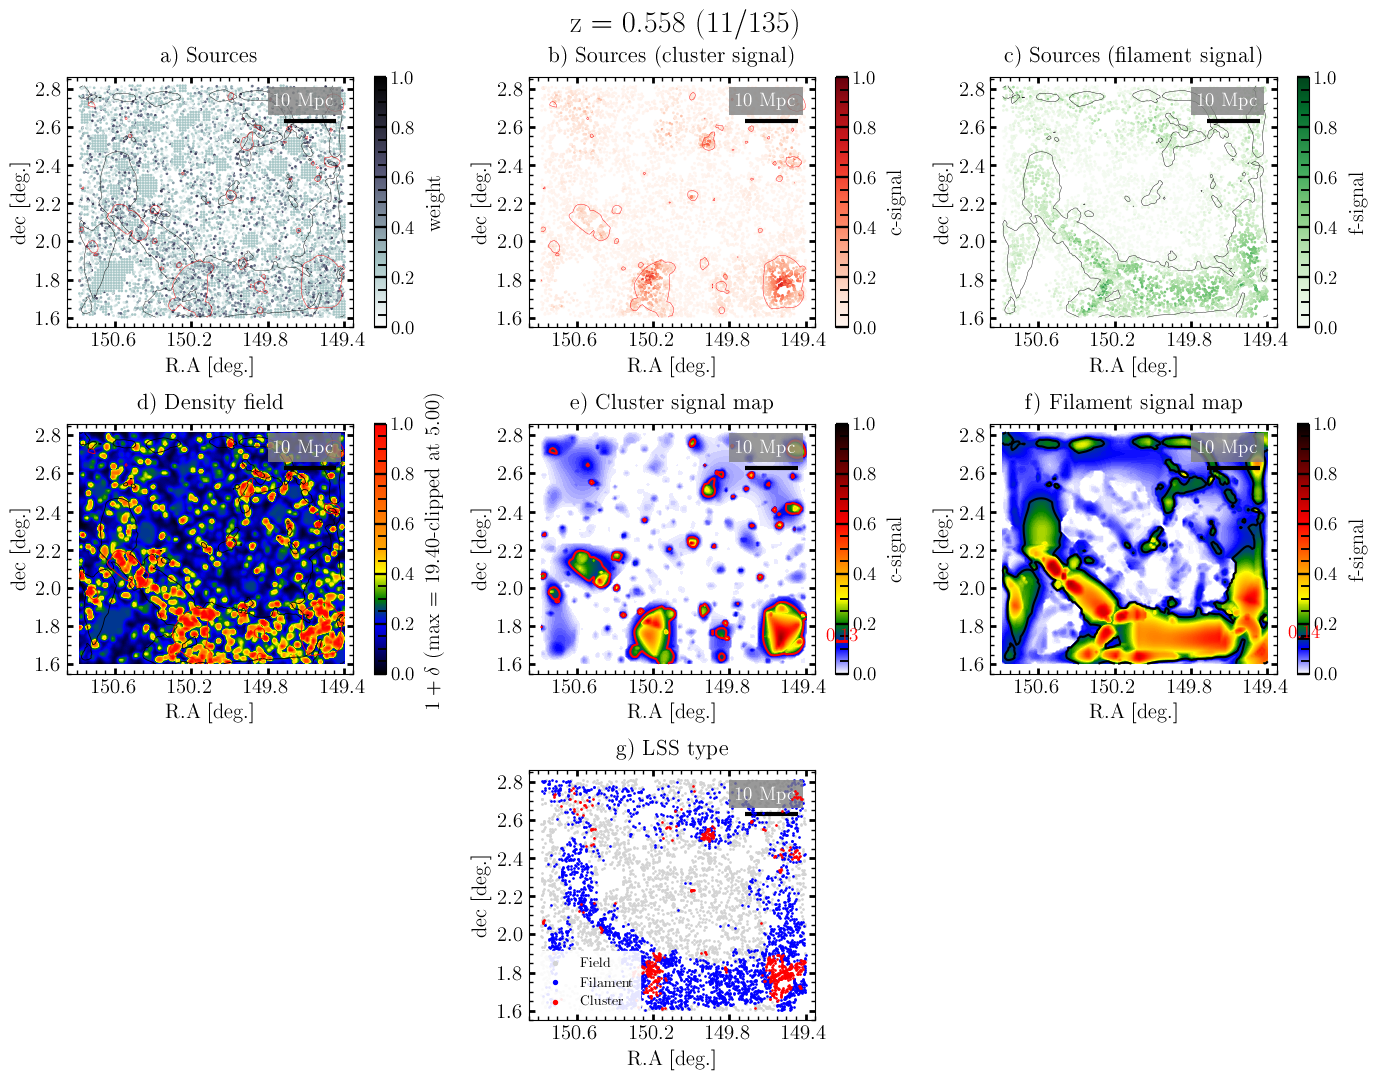

In [18]:
i = 10
full_plot(i, cluster_signal_level = cluster_threshold(slice_centers[i]), filament_signal_level = filament_threshold(slice_centers[i]), save = False)

## 2.2. Signals' catalog

In [49]:
signals_cat = pd.read_csv('./outputs/signals_catalog.csv')
signals_cat

,ID,zPDF,z_No,zPDF_err,RA,dec,den_contrast,comov_den,Phys_den,mass_med,...,sSFR_med,NUVr,rJ,SF/Q,Ks,c_signal,f_signal,LSS_flag,central,group_id
0,12,0.7070,19,0.0314,150.476809,2.331511,0.161998,0.017553,0.087067,8.69380,...,-8.86262,1.25635,0.08144,1.0,23.642779,0.000851,0.056610,0,1,2030
1,27,0.7751,23,0.0730,150.712490,1.792106,0.047502,0.013646,0.076385,8.46963,...,-8.55060,1.32263,0.52481,1.0,24.075852,0.017001,0.214678,1,1,2658
2,29,1.7126,64,0.0582,150.474300,2.333417,0.058440,0.003787,0.076623,9.36002,...,-9.54858,1.51701,0.11895,1.0,23.928368,0.008710,0.140334,1,1,9152
3,36,1.9520,71,0.0729,150.715764,1.792266,-0.054076,0.003202,0.081971,9.04349,...,-7.97090,0.88556,0.40246,1.0,24.434132,0.024746,0.103839,0,0,0
4,38,3.1277,99,0.2208,150.476975,2.333594,0.100354,0.001268,0.090212,10.40829,...,-8.99042,2.50290,0.85170,1.0,23.808557,0.076571,0.059818,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210616,964398,1.4276,53,0.0488,150.445797,2.041274,0.339103,0.008815,0.124685,10.10522,...,-9.13270,2.35704,0.71371,1.0,22.531142,0.013937,0.075637,0,0,0
210617,964399,0.7699,23,0.0146,150.446456,2.041975,-0.047675,0.012407,0.069444,9.05020,...,-7.70040,1.39327,-0.05990,1.0,22.246206,0.000000,0.015175,0,0,0
210618,964400,2.3920,83,0.0905,150.445740,2.042198,0.177343,0.002627,0.102400,10.88157,...,-16.46314,4.30044,1.75908,1.0,22.458117,0.037849,0.009363,0,0,0
210619,964401,0.6936,18,0.0467,150.448750,2.042385,0.931122,0.026653,0.128271,9.18869,...,-8.46581,1.79685,0.40811,1.0,22.327980,0.034774,0.055683,0,1,1957


#### Weights

In [5]:
weight_threshold = 0.05
# It is only weights block: each rows (len data): Galaxy / columns: redshift slices (it is not thresholded, has all weights)
weights_block = np.load('./inputs/WeightsBlock_magcut245.npy')
weights_block_id = np.load('./inputs/weights_block_id.npy')

weight_block_ID = weights_block_id[:, 0]
weight_block_ID = weight_block_ID.astype(int)
indices_signals_cat = np.where(np.isin(weight_block_ID, signals_cat['ID']))[0]
weights_block_cat = weights_block[indices_signals_cat, :]

# Thresholded and normalized (0.05 and 0.10 minimum weight)
# W = np.load('./inputs/WeightsBlock-magcut245-W-th05-normalized.npy')
weights_cat = np.load('./inputs/weights_non0_constrained_05th.npy')

# Finding the places where weight is above threshold
ind = np.array([np.where(weights_block_cat > weight_threshold)[0], np.where(weights_block_cat > weight_threshold)[1]]).T

# gals_bin = []
# for i in range(0, len(slice_centers)):
#     gals_bin.append(np.unique(ind[ind[:, 1] == i, 0]))
    
# inds_th = []
# for i in range(0, len(slice_centers)):
#     inds_th.append(np.where(weights_block[:, i] >= weight_threshold)[0])

## 2.3. Cluster/Filament/Field Classification

**eigenvalues should be ready and stored in `./outputs/eigenvalues/`. Running the cell below calculates cluster/filament signal for ALL SLICES**

### 2.3.1. signal cut

In [5]:
def fraction_occupied(cut, field):
    """
    Calculates the surface area fraction occupied by areas with signal below "cut" 
    and assigns a binomial error estimate.

    Parameters:
    - cut (float): Signal threshold.
    - field (numpy.ndarray): 2D signal map of shape (mesh_y, mesh_x).

    Returns:
    - frac_occ (float): Fraction of area occupied.
    - error (float): Binomial error associated with the fraction.
    """
    N_total = mesh_x * mesh_y  # Total number of points in the field
    
    frac_occ = np.sum(field < cut) / N_total  # Fraction occupied
    error = np.sqrt(frac_occ * (1 - frac_occ) / N_total)  # Binomial error
    
    return frac_occ, error

def power_law(x, a, b):
    return a * np.power(x, b)

def find_intersection(x, y1, y2):
    """Find intersection of two curves."""
    f1 = interp1d(x, y1, kind='linear')
    f2 = interp1d(x, y2, kind='linear')
    xnew = np.logspace(np.log10(x.min()), np.log10(x.max()), num=5000)
    ynew1 = f1(xnew)
    ynew2 = f2(xnew)
    idx = np.argwhere(np.diff(np.sign(ynew1 - ynew2))).flatten()
    return xnew[idx]

def detect_change_point(cuts, fraction_occupied, window, threshold = 0.05, signal_field = 'cluster', poly_order=2):
    """
    Detects the transition point where the second derivative of fraction_occupied
    reaches its most negative value, indicating the strongest downward curvature.

    Parameters:
    - cuts: Array of cut values.
    - fraction_occupied: Array of occupied fractions corresponding to each cut.
    - window: Window size for the Savitzky-Golay filter (should be odd).
    - poly_order: Polynomial order for the filter.

    Returns:
    - change_idx: Index where the second derivative is most negative.
    """
    log_cuts = np.log(cuts)
    d2_frac = np.gradient(np.gradient(fraction_occupied, log_cuts), log_cuts)  # Compute second derivative

    # Smooth the second derivative to reduce noise
    d2_frac_smooth = savgol_filter(d2_frac, window_length=window, polyorder=poly_order, mode='nearest')

    change_idx = np.argmin(d2_frac_smooth)  # Most negative curvature point

    return change_idx

def calculate_best_cut(slice, signal_field = 'cluster', window=7, mesh_x=137, mesh_y=120, save = False):
    cuts = np.logspace(-1.5, 0, 60) 
    
    if signal_field == 'cluster':
        field = np.load(os.path.join(signals_dir, 'cluster_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    elif signal_field == 'filament':
        field = np.load(os.path.join(signals_dir, 'filament_signal_slice=%d_z=%.3f_gamma=%.2f.npy' %(slice, slice_centers[slice], gamma)))
    
    fraction_occupied = np.array([np.sum(field < cut) / (mesh_x * mesh_y) for cut in cuts])
    
    # Detect the transition point using maximum negative curvature in second derivative
    change_index = detect_change_point(cuts, fraction_occupied, window, poly_order=2)
    # Fit two power-law models before and after the transition point
    # params1, _ = curve_fit(power_law, cuts[:change_index], fraction_occupied[:change_index])
    # params2, _ = curve_fit(power_law, cuts[change_index:], fraction_occupied[change_index:])
    
    # Find the intersection
    # intersection = find_intersection(cuts, power_law(cuts, *params1), power_law(cuts, *params2))
    
    # Plotting
    fig = plt.figure(figsize=(8, 5))
    plt.plot(cuts, fraction_occupied, 'ko', label='Fraction below cut')  # Linear y-scale
    # plt.plot(cuts, power_law(cuts, *params1), 'b-', label=r'Power Law 1')
    # plt.plot(cuts, power_law(cuts, *params2), 'r-', label=r'Power Law 2')
    plt.axvline(x=cuts[change_index], color='purple', linestyle=':', label=f'Max Negative Curvature {cuts[change_index]:.3f}')
    # if len(intersection) > 0:
    #     plt.axvline(x=intersection[0], color='green', linestyle='--', label=f'Intersection at {intersection[0]:.2f}')
    plt.xscale('log')  # Log scale on x-axis (signal cuts)
    plt.ylim(0, 1.05)
    plt.xlabel(r'Cut on signal (S$_{c}$)')
    plt.ylabel(r'A$_{<S_{c}}$')
    if signal_field == 'cluster':
        plt.title('Optimal Signal Cut-cluster-slice%d-z=%.3f' %(slice, slice_centers[slice]))
    if signal_field == 'filament':
        plt.title('Optimal Signal Cut-filament-slice%d-z=%.3f' %(slice, slice_centers[slice]))
    plt.legend()
    plt.grid(True, which="both", linestyle="--")
    fig.tight_layout()
    if save:
        if signal_field == 'cluster':
            plt.savefig(os.path.join(outputs_dir , 'plots/signal_cut/clusterCut-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        elif signal_field == 'filament':
            plt.savefig(os.path.join(outputs_dir , 'plots/signal_cut/filamentCut-slice%d-z=%.3f.png' %(slice, slice_centers[slice])), format = 'png', dpi = 250)
        plt.close(fig)
    else:
        plt.show()
    
    return cuts[change_index]

def cluster_threshold(z):
    return (-0.01347994 * z + 0.1376709)

def filament_threshold(z):
    # return (-0.04659437 * z + 0.33504553)
    return (-0.02270 * z + 0.15489)

In [6]:
cluster_cut = np.load('./outputs/cluster_cut.npy')
id_0 = np.where(cluster_cut == 0)[0][0]
# filament_cut = np.load('./outputs/filament_cut.npy')
filament_cut = np.load('./outputs/filament_cuts_number.npy')

### 2.3.2. Classification based on signal cuts

In [17]:
# signals_cat['LSS_flag'] = np.zeros(len(signals_cat))
# signals_cat['LSS_flag'] = signals_cat['LSS_flag'].astype(int)

# # Compute thresholds for all rows at once
cluster_cuts = signals_cat['zPDF'].apply(cluster_threshold)
filament_cuts = signals_cat['zPDF'].apply(filament_threshold)

# # Initialize flag column with default value 0
signals_cat['LSS_flag'] = 0

# # Assign values based on conditions using NumPy's vectorized operations
signals_cat.loc[(signals_cat['c_signal'] > cluster_cuts) & (signals_cat['c_signal'] > signals_cat['f_signal']), 'LSS_flag'] = 2
signals_cat.loc[(signals_cat['f_signal'] > filament_cuts) & (signals_cat['f_signal'] > signals_cat['c_signal']), 'LSS_flag'] = 1

signals_cat.to_csv('./outputs/signals_catalog.csv', index = False)
hdul = fits.PrimaryHDU(signals_cat)
hdul.writeto('./outputs/signals_catalog.fits', overwrite=True)

## 2.4. Animation

In [ ]:
# Usage Example
images_folder = '/Users/sinataamoli/Desktop/COSMOS/COSMOS2020_FILAMENTS/COSMOS2020-filaments/outputs/plots/SDCF_plots'
images_file_names = 'Filament-cluster-slice*-z=*.png'
output_path = './'
output_filename = 'SDCF_slow.mp4'

create_animation_mp4(images_folder, images_file_names, output_path, output_filename, fps=10)

# 3. Running for all z-slices

In [ ]:
# cluster_cut = np.zeros(135)
# filament_cut = np.zeros(135)
signals_cat = pd.read_csv('./outputs/signals_catalog.csv')

for i in tqdm(range(0, 125)):
    # max_signal(i)
    # plot_MMF(i, save = True)
    # plot_scales(i, save = True)
    # cluster_cut[i] = calculate_best_cut(i, signal_field = 'cluster', save = True)
    # filament_cut[i] = calculate_best_cut(i, signal_field = 'filament', save = True)
    
    cluster_cut = cluster_threshold(slice_centers[i])
    filament_cut = filament_threshold(slice_centers[i])
    plot_MMF_signalCat(i, cluster_signal_level = cluster_cut, filament_signal_level = filament_cut, population = True, save = True)
    # full_plot(i, cluster_signal_level = cluster_threshold(slice_centers[i]), filament_signal_level = filament_threshold(slice_centers[i]), save = True)
    
# np.save('./outputs/cluster_cut.npy', cluster_cut)
# np.save('./outputs/filament_cut.npy', filament_cut)

# 3. Science

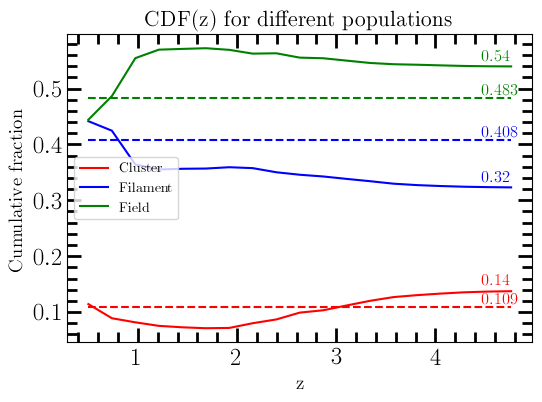

In [56]:
# Plot Cumulative fractions of LSS_flag 0, 1, and 2 up to redshift z as a function of z

z = np.linspace(0.5, 5, 20)
cumul_cluster = np.zeros(len(z))
cumul_filament = np.zeros(len(z))
cumul_field = np.zeros(len(z))

PDF_cluster = np.zeros(len(z))
PDF_filament = np.zeros(len(z))
PDF_field = np.zeros(len(z))


for i in range(0, len(z)-1):
    sub = signals_cat[signals_cat['zPDF'] < z[i]]
    sub1 = signals_cat[(signals_cat['zPDF'] < z[i+1]) & (signals_cat['zPDF'] > z[i])]
    
    cumul_cluster[i] = len(sub[sub['LSS_flag'] == 2]) / len(sub)
    cumul_filament[i] = len(sub[sub['LSS_flag'] == 1]) / len(sub)
    cumul_field[i] = len(sub[sub['LSS_flag'] == 0]) / len(sub)
    
    PDF_cluster[i] = len(sub1[sub1['LSS_flag'] == 2]) / len(signals_cat)
    PDF_filament[i] = len(sub1[sub1['LSS_flag'] == 1]) / len(signals_cat)
    PDF_field[i] = len(sub1[sub1['LSS_flag'] == 0]) / len(signals_cat)
    
plt.figure(figsize=(6, 4))
plt.plot(z[:-1], cumul_cluster[:-1], 'r-', label='Cluster')
plt.plot(z[:-1], cumul_filament[:-1], 'b-', label='Filament')
plt.plot(z[:-1], cumul_field[:-1], 'g-', label='Field')

plt.plot(z[:-1], np.full(len(z)-1, 0.109), 'red', linestyle = 'dashed')
plt.plot(z[:-1], np.full(len(z)-1, 0.408), 'blue', linestyle = 'dashed')
plt.plot(z[:-1], np.full(len(z)-1, 0.483), 'green', linestyle = 'dashed')

# annotate the final number for each curve on the curve

plt.annotate(f'{cumul_cluster[-2]:.2f}', xy=(z[-2], cumul_cluster[-2]), xytext=(z[-2]-0.3, cumul_cluster[-2]+0.01), fontsize=12, color='red')
plt.annotate(f'{cumul_filament[-2]:.2f}', xy=(z[-2], cumul_filament[-2]), xytext=(z[-2]-0.3, cumul_filament[-2]+0.01), fontsize=12, color='blue')
plt.annotate(f'{cumul_field[-2]:.2f}', xy=(z[-2], cumul_field[-2]), xytext=(z[-2]-0.3, cumul_field[-2]+0.01), fontsize=12, color='green')

plt.annotate(f'0.109', xy=(z[-2], 0.109), xytext=(z[-2]-0.3, 0.109+0.005), fontsize=12, color='red')
plt.annotate(f'0.408', xy=(z[-2], 0.408), xytext=(z[-2]-0.3, 0.408+0.005), fontsize=12, color='blue')
plt.annotate(f'0.483', xy=(z[-2], 0.483), xytext=(z[-2]-0.3, 0.483+0.005), fontsize=12, color='green')

plt.xlabel('z', fontsize=14)
plt.ylabel('Cumulative fraction', fontsize=14)
plt.title('CDF(z) for different populations', fontsize=16)

plt.legend()

## Groups (FoF)

### median number density


In [69]:
def fof_grouping(signals_cat, b_perp=1.3, alpha=1.5, photoz_err_factor=0.015, min_group_size=3, max_group_size=50, log_filename='groupingLog'):
    """
    Friends-of-Friends grouping to identify groups and classify galaxies as
    central, satellite, or isolated.

    Parameters:
    - signals_cat: pandas DataFrame with columns ['RA', 'dec', 'zPDF', 'z_No', 'mass_med']
    - b_perp: projected linking length parameter (default 1.0): units of angular separation
    - alpha: redshift linking parameter (default 1.5)
    - photoz_err_factor: photo-z error scaling (default 0.015)
    - min_group_size: minimum group size to keep (default 3)
    - max_group_size: maximum group size to keep (default 50)

    Returns:
    - Updated signals_cat with 'group_id' and 'central' columns.
    """
    log_save_path = os.path.join(outputs_dir, log_filename + f'_b{b_perp:.2f}_a{alpha:.2f}_dz{photoz_err_factor:.3f}.txt')
    
    deg2rad = np.pi / 180
    
    signals_cat = signals_cat.copy()
    signals_cat['central'] = 0
    group_ids = np.full(len(signals_cat), -1)
    central_flags = np.zeros(len(signals_cat), dtype=int)

    unique_slices = np.sort(signals_cat['z_No'].unique())
    group_counter = 0

    logs = []
    
    for z_slice in tqdm(unique_slices, desc="Processing slices"):
        slice_cat = signals_cat[signals_cat['z_No'] == z_slice]
        slice_sources = Slice(z_slice).sources
        slice_sources_cat = slice_sources[slice_sources['ID'].isin(slice_cat['ID'])].copy()
        
        # Effective number of galaxies in slice
        total_weight = slice_sources_cat['w'].sum()
        
        if len(slice_cat) < 2:
            logs.append(f"slice {z_slice}: {len(slice_cat)} galaxies | 0 Groups | 0 Central | 0 Satellite | {len(slice_data)} Isolated")
            continue

        z_mean = slice_cat['zPDF'].median()
        Dc = cosmo.comoving_distance(z_mean).value

        #### Be Cautuious with the units here!        
        ## 2D projected area in Mpc^2
        area_Mpc2 = width * height * (deg2rad * Dc)**2
        n_z = total_weight / area_Mpc2
        d_perp = b_perp * (1 / n_z)**(0.5)
        
        ## 3D volume in Mpc^3
        # n_z = len(slice_cat) / (1.5**2 * np.pi * 35.0)
        # d_perp = b_perp * (1 / n_z)**(1/3)
        
        theta_crit = (d_perp / Dc) * (180 / np.pi) * 3600
        # theta_crit = (d_perp / Dc) # in radians
        z_thresh = alpha * photoz_err_factor * (1 + z_mean)
        ####
        
        coords = SkyCoord(ra=slice_cat['RA'].values * u.deg,
                          dec=slice_cat['dec'].values * u.deg)
        xyz = np.vstack(coords.cartesian.xyz).T
        tree = KDTree(xyz)

        visited = np.zeros(len(slice_cat), dtype=bool)
        slice_group_count = 0
        slice_central_count = 0
        slice_satellite_count = 0

        for idx in range(len(slice_cat)):
            if visited[idx]:
                continue
            current_group = [idx]
            queue = [idx]
            visited[idx] = True

            while queue:
                i = queue.pop()
                z_i = slice_cat.iloc[i]['zPDF']
                # idx_neighbors = tree.query_radius([xyz[i]], r=theta_crit)[0]
                idx_neighbors = tree.query_radius([xyz[i]], r=np.sin(np.deg2rad(theta_crit / 3600)))[0]

                for j in idx_neighbors:
                    if visited[j]:
                        continue
                    z_j = slice_cat.iloc[j]['zPDF']
                    if abs(z_i - z_j) <= z_thresh:
                        queue.append(j)
                        current_group.append(j)
                        visited[j] = True

            if len(current_group) == 1:
                continue

            masses = slice_cat.iloc[current_group]['mass_med'].values
            central_idx = current_group[np.argmax(masses)]

            for j in current_group:
                global_idx = slice_cat.index[j]
                group_ids[global_idx] = group_counter
                if j == central_idx:
                    central_flags[global_idx] = 2
                    slice_central_count += 1
                else:
                    central_flags[global_idx] = 1
                    slice_satellite_count += 1

            slice_group_count += 1
            group_counter += 1

        # Compute isolated
        slice_global_indices = slice_cat.index
        slice_isolated_count = np.sum(central_flags[slice_global_indices] == 0)

        logs.append(f"slice {z_slice}: {len(slice_cat)} galaxies | {slice_group_count} Groups | {slice_central_count} Central | {slice_satellite_count} Satellite | {slice_isolated_count} Isolated")

    # Final Assignment to the catalog
    signals_cat['group_id'] = group_ids
    signals_cat['central'] = central_flags

    # Count group sizes
    group_sizes = signals_cat[signals_cat['group_id'] > 0]['group_id'].value_counts()

    # Filter: keep groups within size limits
    valid_groups = group_sizes[(group_sizes >= min_group_size) & (group_sizes <= max_group_size)].index

    signals_cat.loc[~signals_cat['group_id'].isin(valid_groups), 'group_id'] = 0
    signals_cat['central'] = np.where(signals_cat['group_id'] == 0, 0, signals_cat['central'])
    
    # Final summary stats
    total_groups = len(valid_groups)
    total_central = np.sum(signals_cat['central'] == 2)
    total_satellite = np.sum(signals_cat['central'] == 1)
    total_isolated = np.sum(signals_cat['central'] == 0)

    logs.append(
    f"\nSummary (for b = {b_perp:.2f}, alpha = {alpha:.2f}, and photoz_err_factor = {photoz_err_factor:.3f}): "
    f"{total_groups} Groups | {total_central} Central | {total_satellite} Satellite | {total_isolated} Isolated")

    # print the summary (statement above)
    print(f"\nSummary (for b = {b_perp:.2f}, alpha = {alpha:.2f}, and photoz_err_factor = {photoz_err_factor:.3f}): "
    f"{total_groups} Groups | {total_central} Central | {total_satellite} Satellite | {total_isolated} Isolated")
    
    with open(log_save_path, 'w') as f:
        for line in logs:
            f.write(line + '\n')

            
    return signals_cat, total_groups

def visualize_groups(slice_no):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    slice_cat = signals_cat[signals_cat['z_No'] == slice_no].copy()
    slice_sources = Slice(slice_no).sources
    slice_sources_cat = slice_sources[slice_sources['ID'].isin(slice_cat['ID'])].copy()
    
    # --- Left: spatial distribution with weights ---
    points_cmap = plt.colormaps.get_cmap('bone_r')
    slice_sources = Slice(slice_no).sources
    slice_sources = slice_sources[slice_sources['ID'] != 0]
    axes[0].scatter(slice_sources_cat['ra'], slice_sources_cat['dec'],
                    c=slice_sources_cat['w'], s=0.9, vmin=0, vmax=1, cmap=points_cmap)
    axes[0].set_title(f"Slice {slice_no}: Spatial Distribution with Weights")
    axes[0].set_xlabel("RA")
    axes[0].set_ylabel("Dec")
    axes[0].set_aspect('equal', adjustable='box')
    axes[0].invert_xaxis()

    # --- Right: groups, unique colors, central as diamond, isolated as light gray ---
    slice_data = signals_cat[signals_cat['z_No'] == slice_no]
    grouped = slice_data[slice_data['group_id'] > 0]
    isolated = slice_data[slice_data['group_id'] == 0]

    group_ids = grouped['group_id'].unique()
    cmap = plt.get_cmap('tab20', len(group_ids))

    # Plot grouped galaxies
    for i, gid in enumerate(group_ids):
        sub = grouped[grouped['group_id'] == gid]
        central = sub[sub['central'] == 2]
        satellites = sub[sub['central'] == 1]
        axes[1].scatter(satellites['RA'], satellites['dec'], s=5, color=cmap(i))
        axes[1].scatter(central['RA'], central['dec'], s=20, color=cmap(i), marker='D', edgecolors='black', linewidths=0.5)

    # Plot isolated galaxies
    axes[1].scatter(isolated['RA'], isolated['dec'], s=3, color='lightgray', label='Isolated')

    axes[1].set_title(f"Slice {slice_no}: Groups (colored) + Centrals")
    axes[1].set_xlabel("RA")
    axes[1].set_ylabel("Dec")
    axes[1].set_aspect('equal', adjustable='box')
    axes[1].invert_xaxis()

    plt.tight_layout()
    plt.show()

In [70]:
signals_cat = pd.read_csv('./outputs/signals_catalog.csv')
signals_cat['central'] = 0
signals_cat['group_id'] = 0
signals_cat, No_groups = fof_grouping(signals_cat, b_perp=0.4, alpha=1.5, photoz_err_factor=0.015, min_group_size=3, max_group_size=50, log_filename='groupingLog')

Processing slices: 100%|██████████| 126/126 [00:20<00:00,  6.06it/s]



Summary (for b = 0.40, alpha = 1.50, and photoz_err_factor = 0.015): 22376 Groups | 22376 Central | 106369 Satellite | 81876 Isolated


In [76]:
signals_cat.to_csv('./outputs/signals_catalog.csv', index=False)

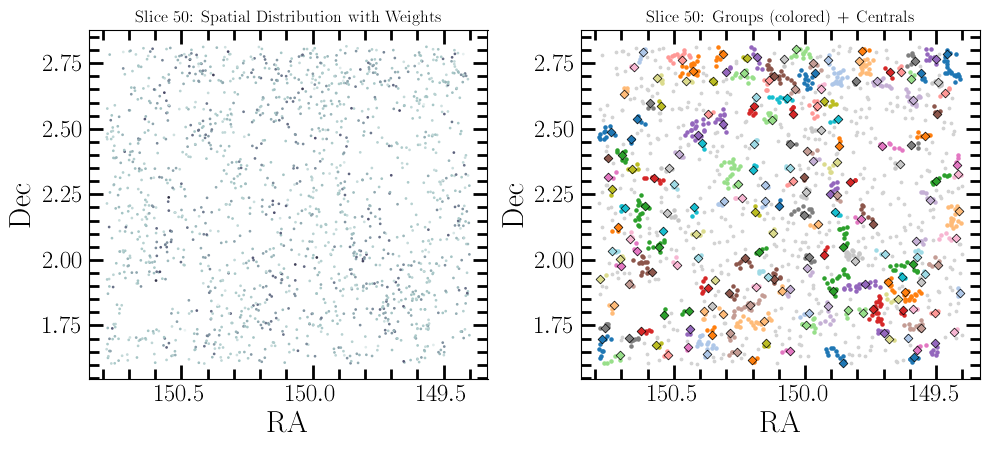

In [73]:
visualize_groups(50)

## Physical Properties vs. Environment

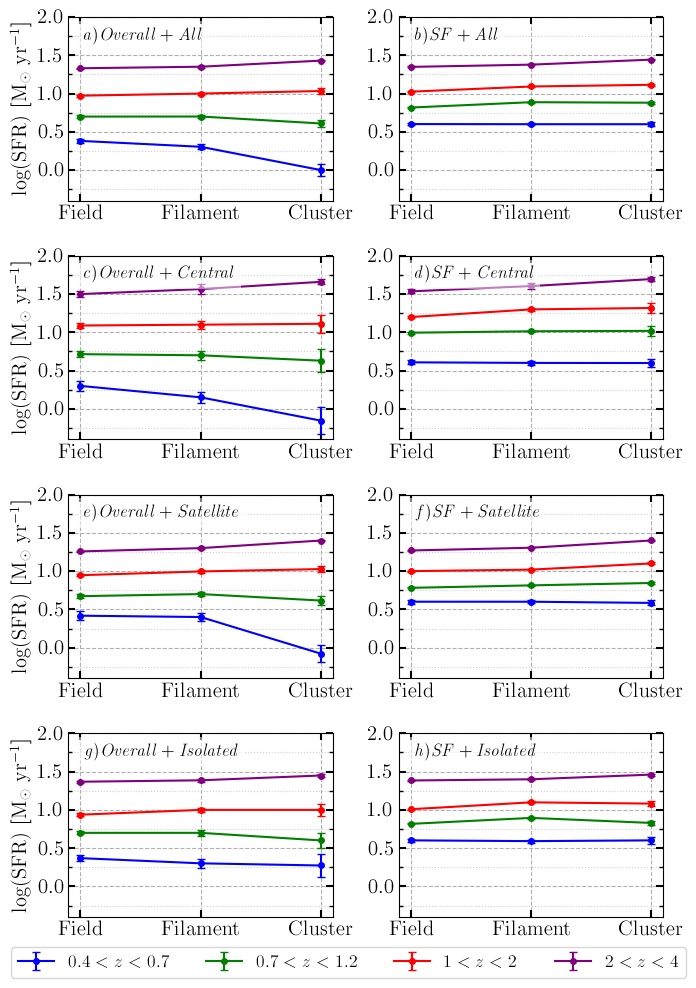

In [84]:
def format_axis(ax, title, ylabel, env_indices, env_labels, 
                title_size=15, label_size=15, ylim=None, 
                x_major_tick_length=5, x_minor_tick_length=3, 
                x_major_tick_width=1.5, x_minor_tick_width=1,
                y_major_tick_length=5, y_minor_tick_length=3, 
                y_major_tick_width=1.5, y_minor_tick_width=1,
                x_minor_ticks=False, y_minor_ticks=True):

    ax.set_title(title, fontsize=title_size)
    ax.set_ylabel(ylabel, fontsize=label_size)
    ax.set_xticks(env_indices)
    ax.set_xticklabels(env_labels, fontsize=label_size)
    ax.grid(True, linestyle='--', which='major')
    
    # X-axis tick formatting
    if x_minor_ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
    else:
        ax.xaxis.set_minor_locator(plt.NullLocator())

    ax.tick_params(axis='x', which='major', length=x_major_tick_length, width=x_major_tick_width)
    ax.tick_params(axis='x', which='minor', length=x_minor_tick_length, width=x_minor_tick_width)
    
    # Y-axis tick formatting
    if y_minor_ticks:
        ax.yaxis.set_minor_locator(AutoMinorLocator())
    else:
        ax.yaxis.set_minor_locator(plt.NullLocator())

    ax.tick_params(axis='y', which='major', length=y_major_tick_length, width=y_major_tick_width)
    ax.tick_params(axis='y', which='minor', length=y_minor_tick_length, width=y_minor_tick_width)
    
    ax.grid(True, linestyle=':', which='minor', alpha=0.6)

    # Set y-axis limit if specified
    if ylim is not None:
        ax.set_ylim(ylim)

# def bin_selection(zmin, zmax, sfq=None, ks_cut=24.5, percentile=90):
#     """
#     Selects mass-complete subset of galaxies for a given redshift bin and optional SF/Q class.

#     Parameters:
#     - zmin, zmax: Redshift bounds
#     - sfq: If 1, selects star-forming; if 0, quiescent; if None, selects all
#     - ks_cut: Ks-band magnitude limit (default: 24.5)
#     - percentile: Percentile to define mass completeness limit (default: 90)

#     Returns:
#     - pandas DataFrame: mass-complete galaxy subset within the specified bin
#     """
#     subset = signals_cat[(signals_cat['zPDF'] >= zmin) & (signals_cat['zPDF'] < zmax)]
#     if sfq is not None:
#         subset = subset[subset['SF/Q'] == sfq]

#     # Compute limiting mass for each galaxy
#     logMlim = subset['mass_med'] + 0.4 * (subset['Ks'] - ks_cut)

#     # Determine 90th percentile of limiting mass
#     threshold = np.percentile(logMlim, percentile)

#     # Select galaxies above the threshold
#     return subset[subset['mass_med'] >= threshold]

def bin_selection(zmin, zmax, global_completeness=False, sfq=None, central_flag=None, ks_cut=24.5, percentile=90):
    subset = signals_cat[(signals_cat['zPDF'] >= zmin) & (signals_cat['zPDF'] < zmax)]

    if sfq is not None:
        subset = subset[subset['SF/Q'] == sfq]

    if central_flag is not None:
        subset = subset[subset['central'] == central_flag]

    if global_completeness:
        mass_limit = 9.3  # Example fixed global limit for all redshifts (can be tuned)
    else:
        # Estimate limiting mass for each galaxy:
        subset = subset.copy()
        subset['Mlim'] = subset['mass_med'] + 0.4 * (subset['Ks'] - ks_cut)
        mass_limit = np.percentile(subset['Mlim'], percentile)

    return subset[subset['mass_med'] >= mass_limit]



def plot_properties(z_bins, parameter, save = False, global_completeness = False):

    colors = ['blue', 'green', 'red', 'purple']
    env_labels = ['Field', 'Filament', 'Cluster']
    env_indices = [0, 1, 2]
    cap = 3
    marker = 4
    label_size = 15
    yax_labels = {'SFR_med': r'$\mathrm{log(SFR)}$ [M$_{\odot}$ yr$^{-1}$]', 'sSFR_med': r'$\mathrm{log(sSFR)}$ [yr$^{-1}$]',
                  'mass_med': r'$\mathrm{log(M)}$ [M$_{\odot}$]'}
    params_ylim = {'SFR_med': (-0.4, 2), 'sSFR_med': (-2, 1), 'mass_med': (9.4, 11)}
    
    if save is True:
        save_name = 'propsvsLSS_%s' % parameter.split('_')[0]
        if global_completeness:
            save_name += '_globalCompleteness'
        save_name += '.png'
    
    
    # Setting up the figure with 4 rows and 2 columns
    fig, axes = plt.subplots(4, 2, figsize=(7, 10), sharex=False, sharey='row')
    
    # Define the configurations for each subplot
    plot_configs = [
        (0, 0, None, None, "a) Overall + All"),
        (0, 1, 1, None, "b) SF + All"),
        (1, 0, None, 2, "c) Overall + Central"),
        (1, 1, 1, 2, "d) SF + Central"),
        (2, 0, None, 1, "e) Overall + Satellite"),
        (2, 1, 1, 1, "f) SF + Satellite"),
        (3, 0, None, 0, "g) Overall + Isolated"),
        (3, 1, 1, 0, "h) SF + Isolated"),
    ]
    yaxislabel = yax_labels[parameter]
    param_ylim = params_ylim[parameter]
        
    for (row, col, sfq, central, label) in plot_configs:
        for (z_label, (zmin, zmax)), color in zip(z_bins.items(), colors):
            # Select the subset of galaxies based on SF/Q and central status
            subset = bin_selection(zmin, zmax, global_completeness, sfq=sfq, central_flag=central, ks_cut=24.5, percentile=90)

            # Median and error calculation for SFR
            param_median, param_err = [], []
            for flag in env_indices:
                group = subset[subset['LSS_flag'] == flag][parameter]
                param_median.append(np.median(group))
                param_err.append(group.std() / np.sqrt(len(group)))
            axes[row, col].errorbar(env_indices, param_median, yerr=param_err, fmt='o', linestyle='-', color=color, markersize=marker, capsize=cap, label=z_label)
        
        # Formatting and annotation
        if col == 0:
            format_axis(axes[row, col], "", yaxislabel, 
                        env_indices, env_labels, ylim = param_ylim)
            axes[row, col].yaxis.set_tick_params(labelleft=True, labelsize=label_size)
        if col == 1:
            format_axis(axes[row, col], "", yaxislabel, 
                        env_indices, env_labels, ylim=param_ylim)
            axes[row, col].yaxis.set_tick_params(labelleft=True, labelsize=label_size)
            axes[row, col].set_ylabel("")  # Remove axis label text

            # Set the major ticks to be spaced by 0.5
            from matplotlib.ticker import MultipleLocator
            y_min, y_max = param_ylim
            axes[row, col].yaxis.set_major_locator(MultipleLocator(0.5))
            axes[row, col].yaxis.set_minor_locator(MultipleLocator(0.25))  # Optional: finer ticks for minors

            
        axes[row, col].annotate(r"$\it{" + label + "}$", xy=(0.06, 0.9), xycoords='axes fraction', ha='left', va='center', style='italic',
                                fontsize=label_size-2, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Adjust the layout
    plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.05, wspace=0.25, hspace=0.3)

    # Shared legend at the bottom
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=len(z_bins), fontsize=13)

    # Save or show
    if save:
        plt.savefig(os.path.join(outputs_dir, 'plots', save_name), format = "png", dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
z_bins = {r'$0.4 < z < 0.7$': (0.4, 0.7), r'$0.7 < z < 1.2$': (0.7, 1.2), r'$1 < z < 2$': (1, 2), r'$2 < z < 4$': (2, 4)}
plot_properties(z_bins, 'SFR_med', save = False, global_completeness = True)